In [1]:
import json

from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import pandas as pd
import numpy as np
import re

from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
from postal.parser import parse_address
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import spline
from sklearn.cluster import DBSCAN
from collections import Counter
import json
import networkx as nx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD



fontsize = 18
figsize = (15,10)
plot_alpha = 0.3
linewidth = 4

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [3]:
def str_to_point(s):
    if s is None:
        return None
    l = s.split(' ')
    return {'long': float(l[0]), 'lat': float(l[1])}

In [4]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)
test = test.rename(columns={'atm_group': '0-bank'})
train = train.rename(columns={'atm_group': '0-bank'})
banks = np.uint(np.sort(test['0-bank'].unique() * 10))

with open('missed_coords.json', 'r') as infile:
    missed_coords = json.load(infile)

In [5]:
missed_coords = [(str_to_point(item[0]), item[1], item[2], item[3]) for item in missed_coords]

In [6]:
test = test.rename(columns={'lat': '6-lat', 'long': '6-long'})
train = train.rename(columns={'lat': '6-lat', 'long': '6-long'})

In [7]:
cities = pd.read_csv('data/cities.csv')
cities['Город'] = cities['Город'].apply(lambda x: x.replace('-', ' ').lower().replace('город ', '').replace(' город', '').replace('ё', 'e') if type(x) == str else '')
cities['Регион'] = cities['Регион'].apply(lambda x: x.replace('-', ' ').lower().replace('ё', 'e') if type(x) == str else '')
cities.loc[cities['Город'] == '', 'Город'] = cities.loc[cities['Город'] == '', 'Регион']
cities.loc[cities['Население'] == '96[3]', 'Население'] = 20000
cities['Население'] = cities['Население'].astype(int)

In [8]:
path = 'banki.ru/desc/'
onlyfiles = sorted([f for f in listdir(path) if isfile(join(path, f))])
all_descs = []
for f in tqdm(onlyfiles):
    fd = open(path + f)
    all_descs += json.load(fd)
    fd.close()

100%|██████████| 280/280 [00:01<00:00, 163.44it/s]


# Prepare

In [9]:
test['0-bank'] = np.uint(test['0-bank'] * 10)
train['0-bank'] = np.uint(train['0-bank'] * 10)
columns_for_drop = ['address', 'address_rus']

### Запоминаем индексы

In [10]:
train['is_train'] = True
test['is_train'] = False
test['index'] = test.index + 1
train['index'] = train.index + 1
train['train_index'] = train.index + 1
test['test_index'] = test.index + 1
train['test_index'] = 0
test['train_index'] = 0
train['index'] = train.index

### Создаём общие данные tran-test

In [11]:
data_all = train.append(test, sort=False)

data_all['address_fail'] = 0
data_all.at[data_all['address_rus'].isnull(), 'address_fail'] = 1
data_all['base_target'] = data_all['target']
data_all.at[(data_all['address_fail'] == 1) & (data_all['is_train']), 'target'] = 0

data_all['address_rus'] = data_all['address_rus'].fillna('')

counts = data_all.groupby('address_rus')['id'].count().reset_index().rename(columns={'id':'the_same_address_terminals'})
data_all = pd.merge(data_all, counts, how='left', on='address_rus')
data_all.at[data_all['address_fail'] == 1, 'the_same_address_terminals'] = 0

### Fillna for address_rus

In [12]:
data_all.at[data_all['address_fail'], 'address_rus'] = data_all['address_rus'].fillna("")

### Fillna for lat, long

In [13]:
data_all.at[:, ['6-lat', '6-long']] = data_all[['6-lat', '6-long']].fillna(0)

### Создаём one-hot-encoding for bank

In [14]:
data_all['0-bank_base'] = data_all['0-bank']
data_all = pd.get_dummies(data_all, columns=['0-bank'], prefix='0-bank')

### Fill missed coords


In [15]:
missed_ids = [item[3] for item in missed_coords]
missed_cities = [item[2] for item in missed_coords]
missed_levels = [1 if item[1] == 'Level.HOUSE' else 0 for item in missed_coords]
missed_lats = [item[0]['lat'] if item[0] is not None else None for item in missed_coords]
missed_longs = [item[0]['long'] if item[0] is not None else None for item in missed_coords]

set_missed_ids = set(missed_ids)
missed_inds = data_all['id'].apply(lambda el: el in set_missed_ids)

In [16]:
data_all.at[missed_inds, '6-lat'] = missed_lats
data_all.at[missed_inds, '6-long'] = missed_longs
data_all['6-levels'] = 1
data_all.at[missed_inds, '6-levels'] = missed_levels
data_all.at[missed_inds, 'city'] = ['' if city is None else city.lower() for city in missed_cities]
data_all['address_fail'] = 0
data_all['address_fail'] = data_all['6-lat'].isnull()
data_all.at[:, ['6-lat', '6-long']] = data_all[['6-lat', '6-long']].fillna(0)

### Make targets

In [17]:
y_all = data_all[['target', 'base_target', 'is_train', 'address_fail']]
y_all['index'] = data_all['index']
y_all['id'] = data_all['id']
data_all = data_all.drop(['target', 'base_target'], axis=1)

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Запоминаем ID-Index

In [18]:
data_all['id'] = data_all['id'].astype(np.uint)

data_all = data_all.rename(columns={'id': '7-id', 'index': '7-index'})
y_all = y_all.rename(columns={'id': '7-id', 'index': '7-index'})

* 80830 -- rosbank
* 10220 -- акбарс
* 19420 -- альфабанк
* 31855 -- газпромбанк
* 320 -- райффайзен
* 4965 -- россельхозбанк
* 54780 -- уралсиб

# Research

100%|██████████| 70/70 [00:00<00:00, 717.52it/s]


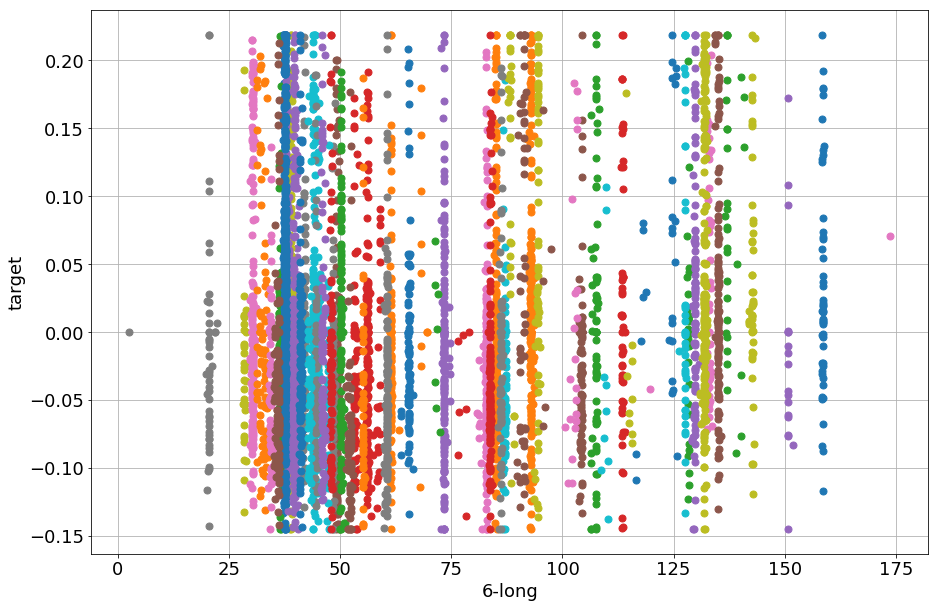

In [19]:
y_label = 'target'
col = '6-long'

km = KMeans(n_clusters=70, n_init=30, max_iter=300, random_state=42)
km.fit([[k]for k in list(data_all[col].values)])
l = km.labels_

plt.figure(figsize=figsize)
for i in tqdm(np.unique(l)):
    x = data_all[col].values[l == i]
    y = y_all[y_label].values[l == i]
    plt.plot(x[x > 0], y[x > 0], '.', markersize=14)
plt.xlabel(col, fontsize=fontsize)
plt.ylabel(y_label, fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.xlim([15, 35])
# plt.xlim([35, 40])
# plt.xlim([37, 38])
# plt.xlim([50, 55])
plt.grid(True)

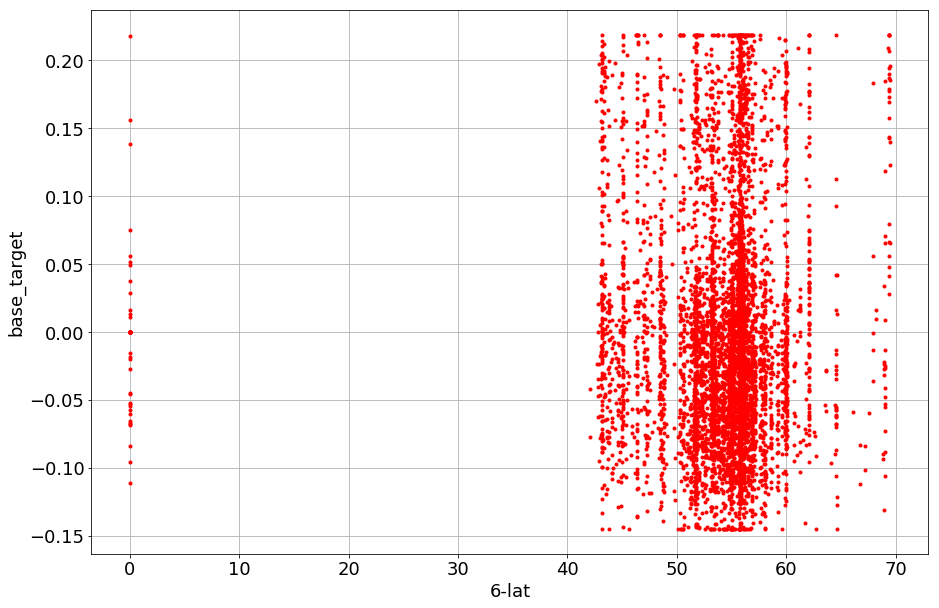

In [22]:
y_label = 'target'
plt.figure(figsize=figsize)
plt.plot(data_all['6-lat'].values, y_all[y_label].values, 'r.')
plt.xlabel('6-lat', fontsize=fontsize)
plt.ylabel('base_target', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)

In [23]:
not_valid = (y_all['address_fail'] == 1).values

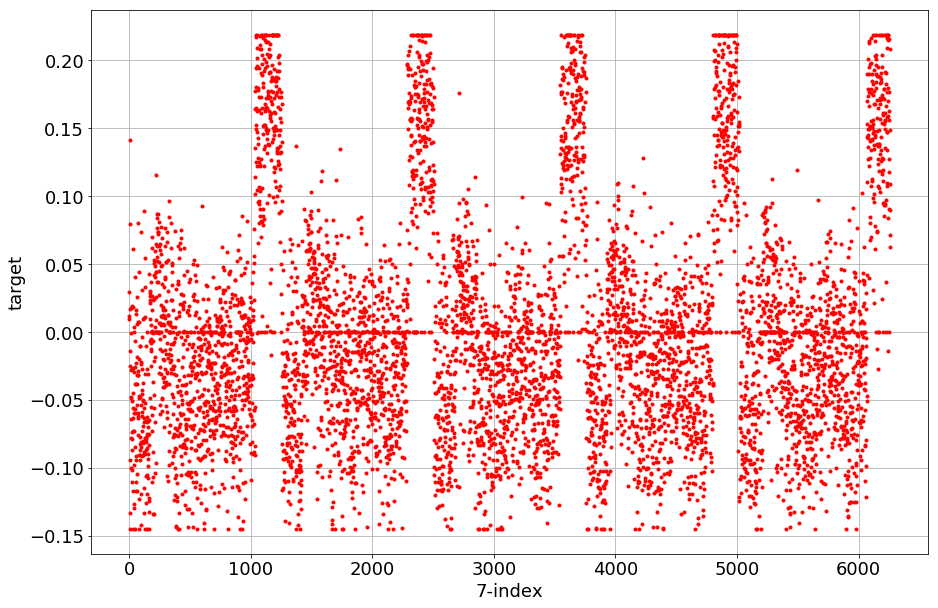

In [24]:
plt.figure(figsize=figsize)
plt.plot(y_all.sort_values('7-index')['7-index'].values, y_all.sort_values('7-index')['target'], 'r.')
plt.xlabel('7-index', fontsize=fontsize)
plt.ylabel('target', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)

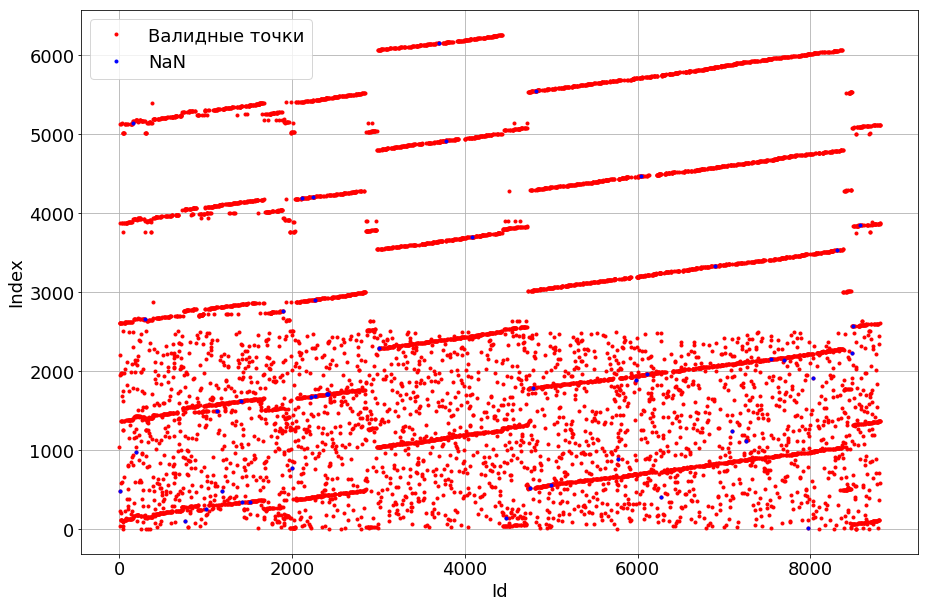

In [25]:
plt.figure(figsize=figsize)
plt.plot(data_all['7-id'].values, data_all['7-index'], 'r.')
plt.plot(data_all[not_valid]['7-id'].values, data_all[not_valid]['7-index'], 'b.')
plt.xlabel('Id', fontsize=fontsize)
plt.ylabel('Index', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(['Валидные точки', 'NaN'], fontsize=fontsize)
plt.grid(True)

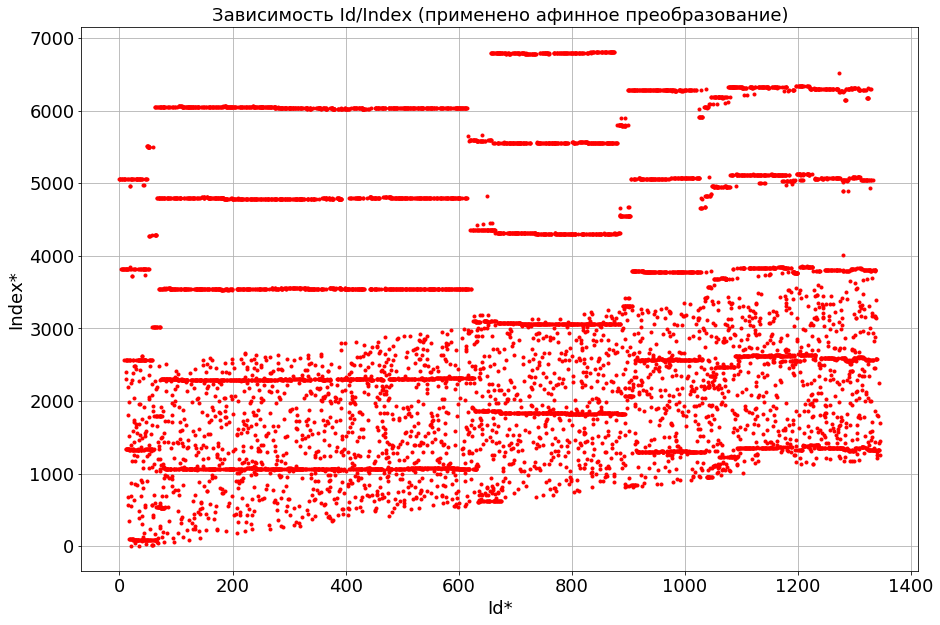

In [26]:
rotate = lambda fi: np.array([[np.cos(fi), -np.sin(fi)], [np.sin(fi), np.cos(fi)]])

x, y = data_all['7-id'].values, data_all['7-index']

m = np.dot(np.array([x, y]).T, rotate(np.pi / 22.3 + np.pi / 2))
m = np.dot(m, np.array([[1, 0.12],[0, 1]]))
m = np.dot(m, np.array([[1.0, 0],[0, 0.15]]))

min_0 = m[:, 0].min()
min_1 = m[:, 1].min()
m = m - np.array([[min_0, min_1]] * m.shape[0])

plt.figure(figsize=figsize)
plt.plot(m[:, 1], m[:, 0], 'r.')
plt.title('Зависимость Id/Index (применено афинное преобразование)', fontsize=fontsize)
plt.xlabel('Id*', fontsize=fontsize)
plt.ylabel('Index*', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)

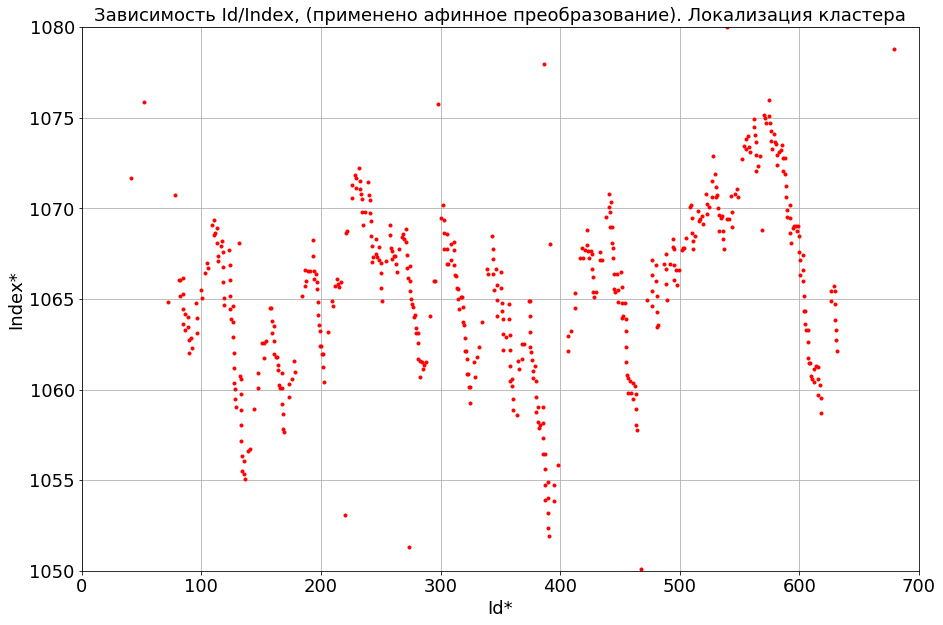

In [27]:
rotate = lambda fi: np.array([[np.cos(fi), -np.sin(fi)], [np.sin(fi), np.cos(fi)]])

x, y = data_all['7-id'].values, data_all['7-index']

m = np.dot(np.array([x, y]).T, rotate(np.pi / 22.3 + np.pi / 2))
m = np.dot(m, np.array([[1, 0.12],[0, 1]]))
m = np.dot(m, np.array([[1, 0],[0, 0.15]]))

min_0 = m[:, 0].min()
min_1 = m[:, 1].min()
m = m - np.array([[min_0, min_1]] * m.shape[0])

plt.figure(figsize=figsize)
plt.plot(m[:, 1], m[:, 0], 'r.')
plt.title('Зависимость Id/Index, (применено афинное преобразование). Локализация кластера', fontsize=fontsize)
plt.xlabel('Id*', fontsize=fontsize)
plt.ylabel('Index*', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlim([0, 700])
plt.ylim([1050, 1080])
plt.grid(True)

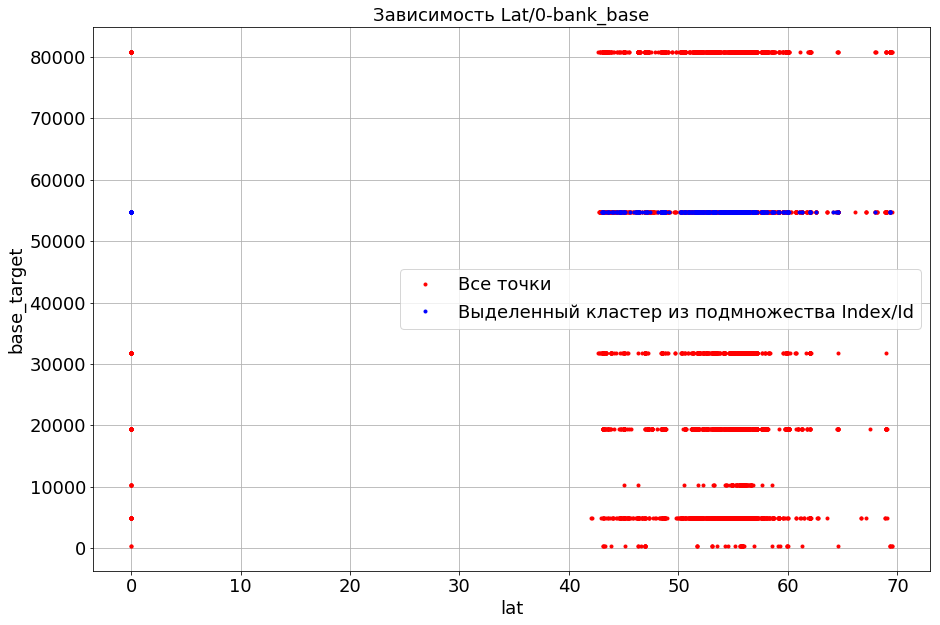

In [28]:
inds = (m[:, 1] < 620) & (m[:, 0] > 5900)

plt.figure(figsize=figsize)
plt.plot(data_all['6-lat'].values, data_all['0-bank_base'].values, 'r.')
plt.plot(data_all['6-lat'].values[inds], data_all['0-bank_base'].values[inds], 'b.')
plt.xlabel('lat', fontsize=fontsize)
plt.ylabel('base_target', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title('Зависимость Lat/0-bank_base', fontsize=fontsize)
plt.legend(['Все точки', 'Выделенный кластер из подмножества Index/Id'], fontsize=fontsize)
plt.grid(True)

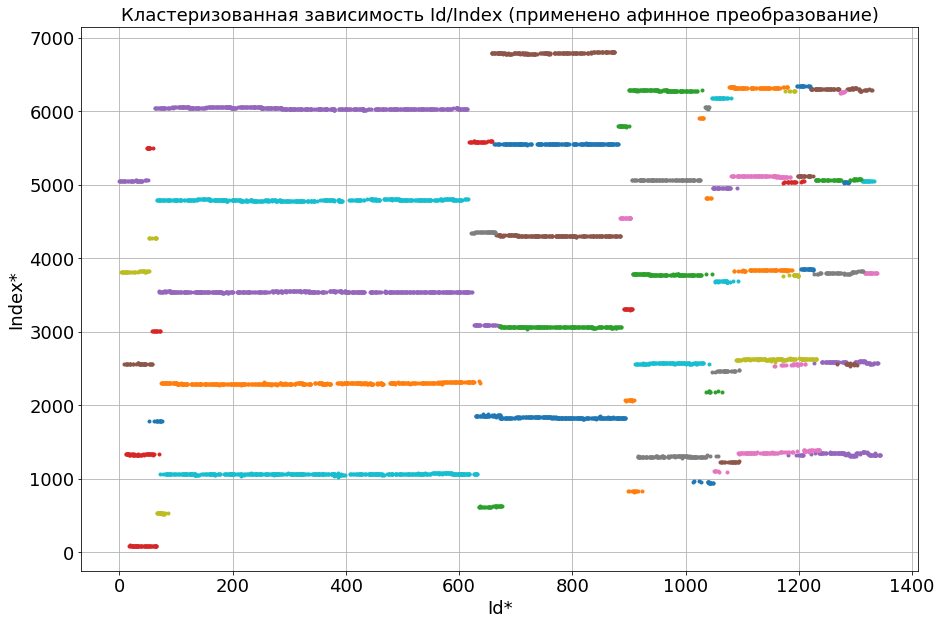

In [29]:
dbscan = DBSCAN(eps=18, min_samples=8)
clusters = dbscan.fit_predict(m)

plt.figure(figsize=figsize)
for cluster in np.unique(clusters):
    inds = clusters == cluster
    if cluster == -1:
        continue
    plt.plot(m[inds, 1], m[inds, 0], '.')
plt.title('Кластеризованная зависимость Id/Index (применено афинное преобразование)', fontsize=fontsize)
plt.xlabel('Id*', fontsize=fontsize)
plt.ylabel('Index*', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)

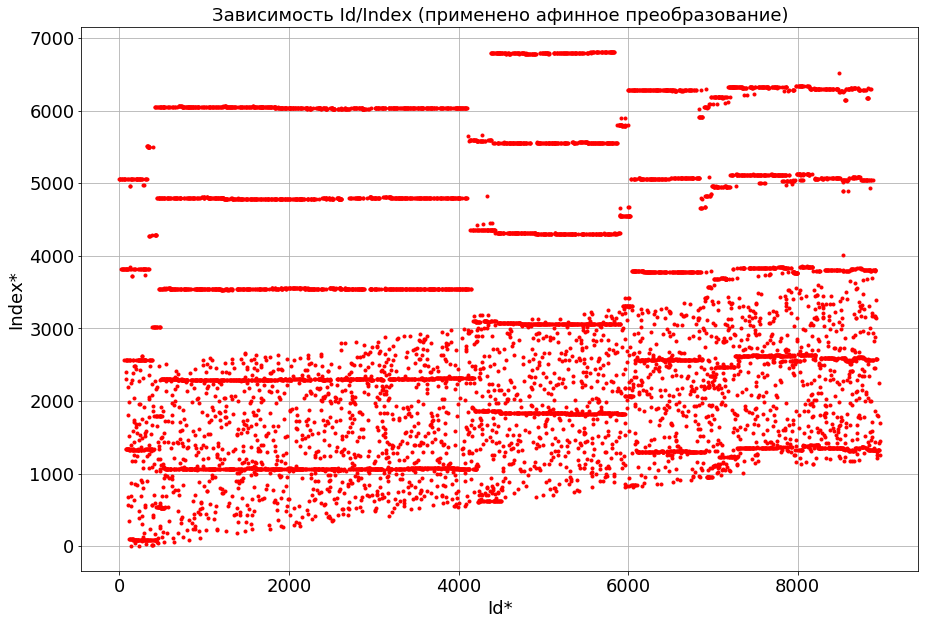

In [30]:
rotate = lambda fi: np.array([[np.cos(fi), -np.sin(fi)], [np.sin(fi), np.cos(fi)]])

x, y = data_all['7-id'].values, data_all['7-index']

m = np.dot(np.array([x, y]).T, rotate(np.pi / 22.3 + np.pi / 2))
m = np.dot(m, np.array([[1, 0.12],[0, 1]]))
m = np.dot(m, np.array([[1, 0],[0, 1]]))

min_0 = m[:, 0].min()
min_1 = m[:, 1].min()
m = m - np.array([[min_0, min_1]] * m.shape[0])

plt.figure(figsize=figsize)
plt.plot(m[:, 1], m[:, 0], 'r.')
plt.title('Зависимость Id/Index (применено афинное преобразование)', fontsize=fontsize)
plt.xlabel('Id*', fontsize=fontsize)
plt.ylabel('Index*', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)

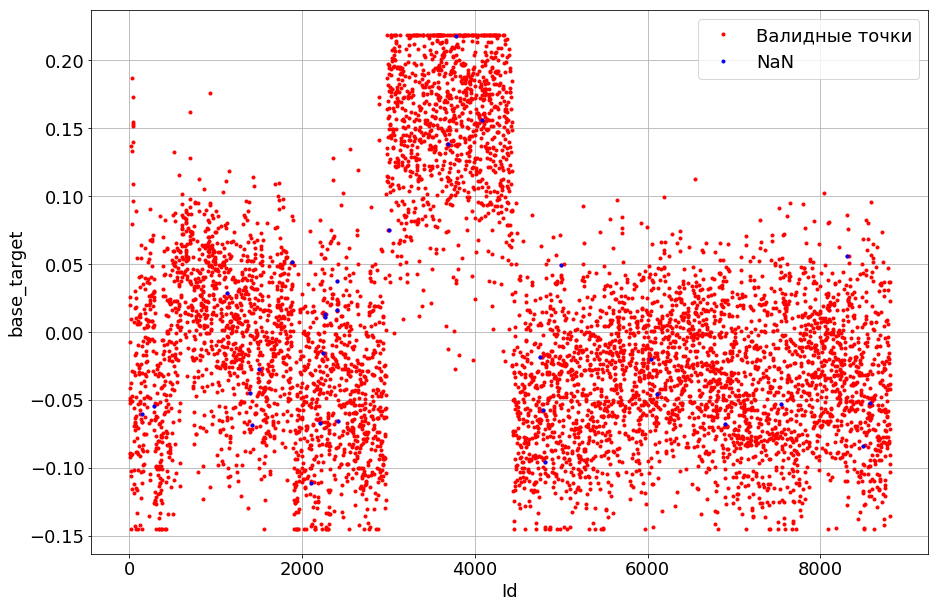

In [31]:
plt.figure(figsize=figsize)
plt.plot(data_all['7-id'].values, y_all['base_target'], 'r.')
plt.plot(data_all[not_valid]['7-id'].values, y_all[not_valid]['base_target'], 'b.')
plt.xlabel('Id', fontsize=fontsize)
plt.ylabel('base_target', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(['Валидные точки', 'NaN'], fontsize=fontsize)
plt.grid(True)

In [32]:
def plot_geo_meta(xlabel='Долгота', ylabel='Широта', title='Расположение банкоматов в обучающей выборке'):
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlim([15, 165])
    plt.ylim([40, 70])
    plt.grid(True)
    
def plot_geo_moscow_piter(plot_alpha=plot_alpha, c='r'):
    plt.plot(37 + 36/60., 55 + 45/60., 'ro', alpha=plot_alpha)
    plt.text(37 + 36/60.-14, 55 + 45/60., 'Москва', color='r', fontsize=fontsize)
    plt.plot(30 + 18/60., 59 + 56/60., 'ro', alpha=plot_alpha)
    plt.text(30 + 18/60.-12, 59 + 56/60., 'Питер', color='r', fontsize=fontsize);

Различные банки (**atm_group**), кажется, не связаны с географией

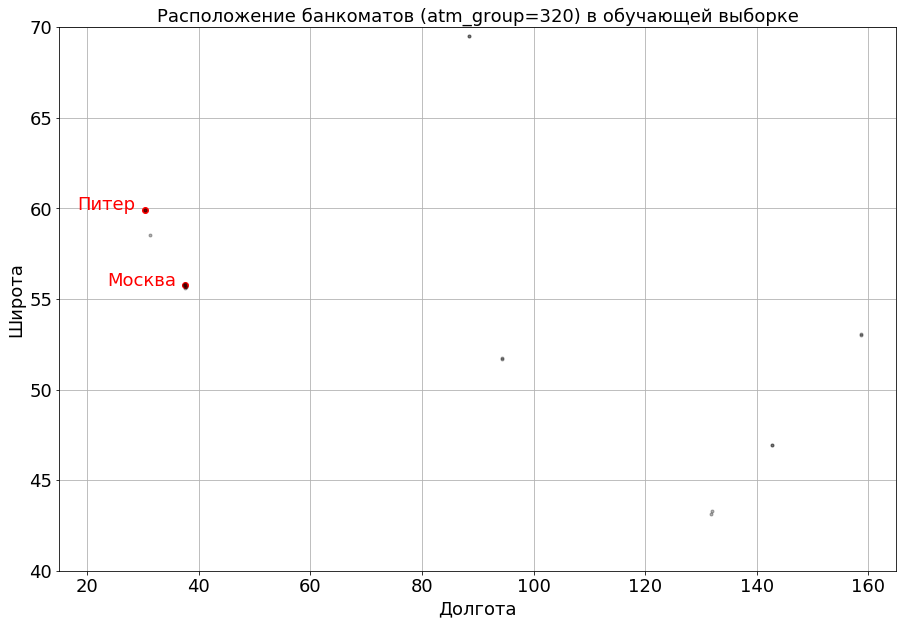

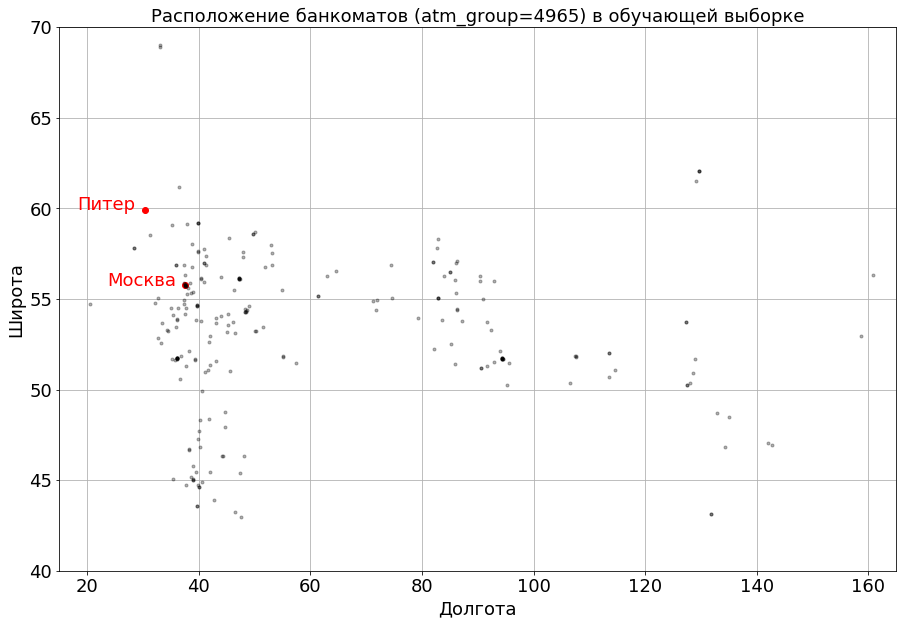

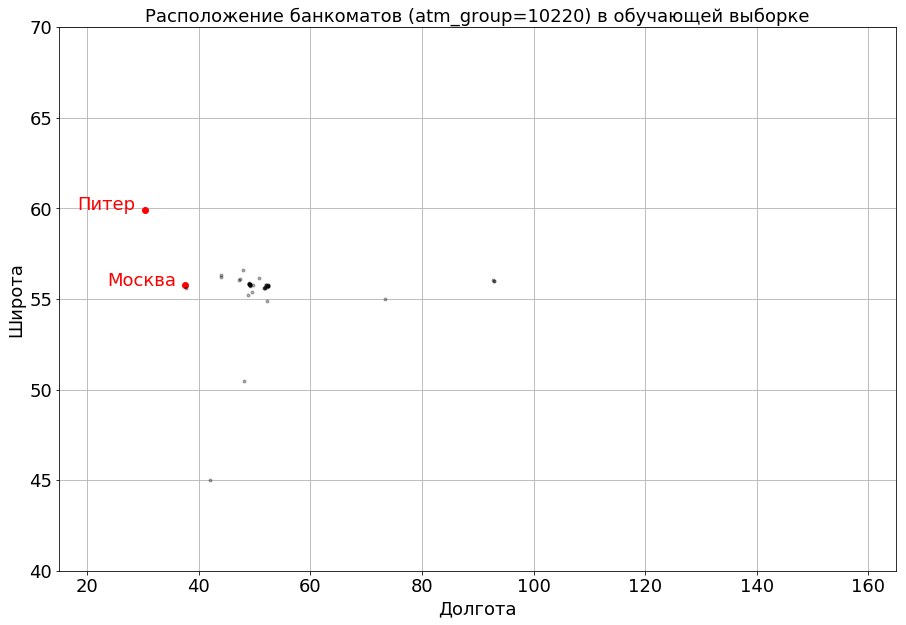

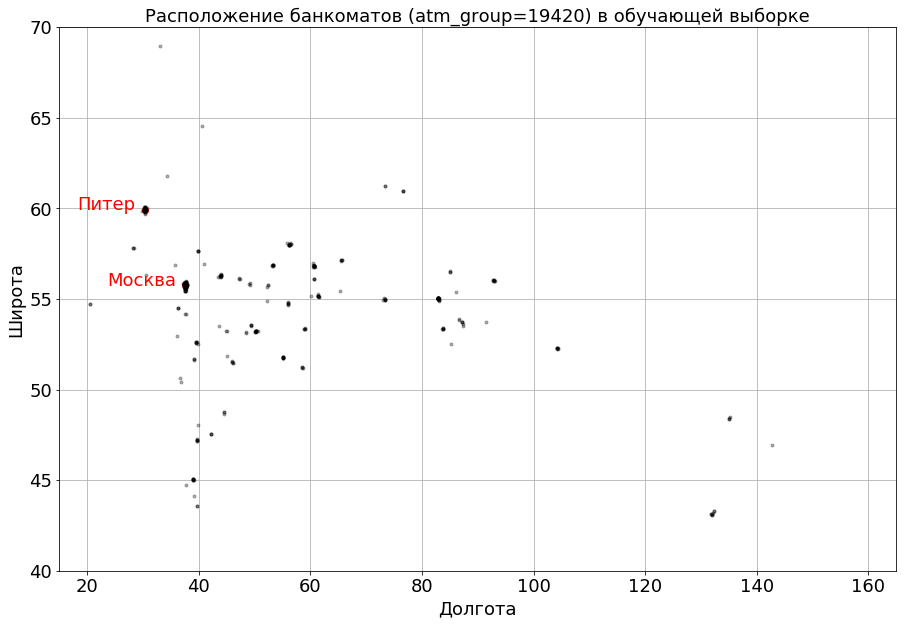

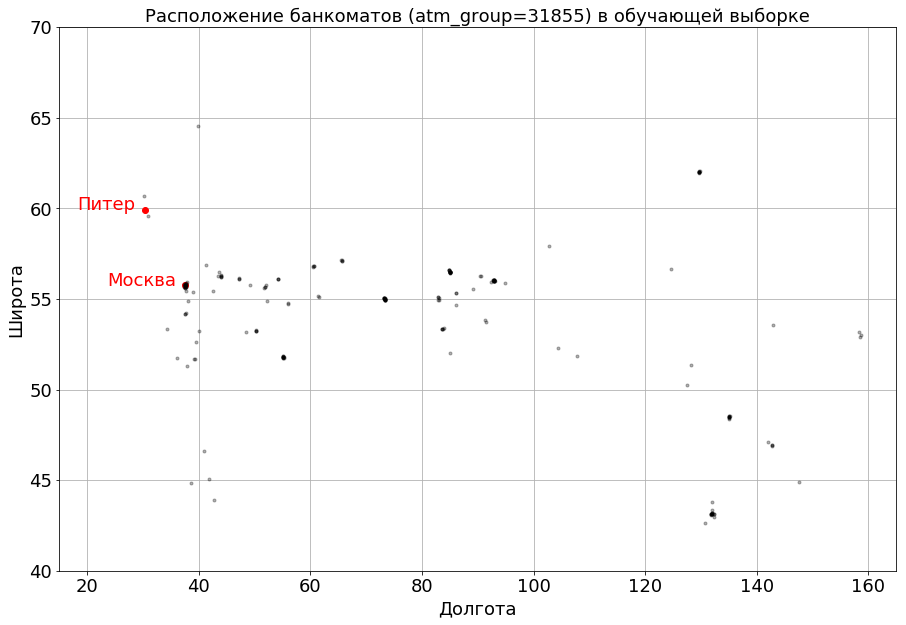

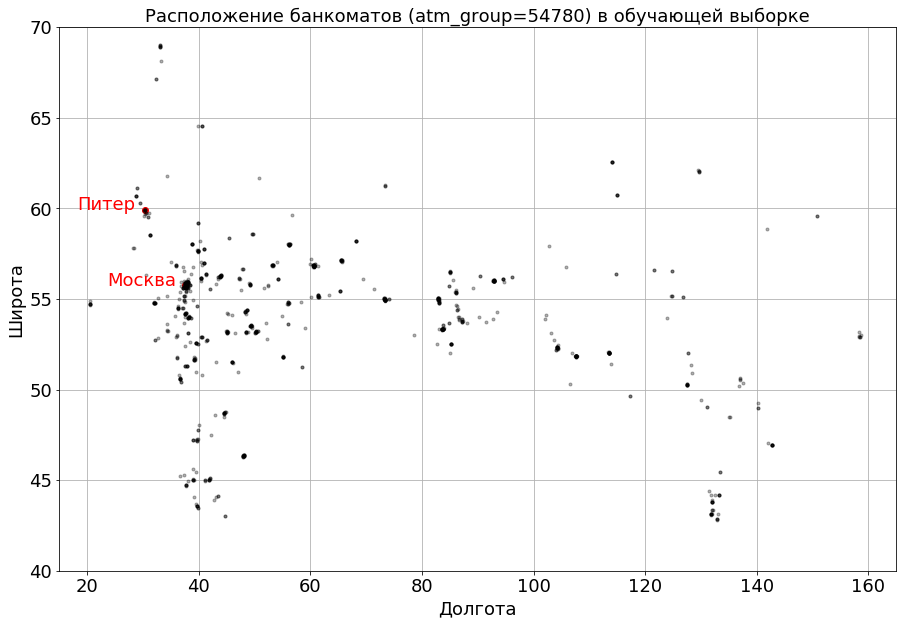

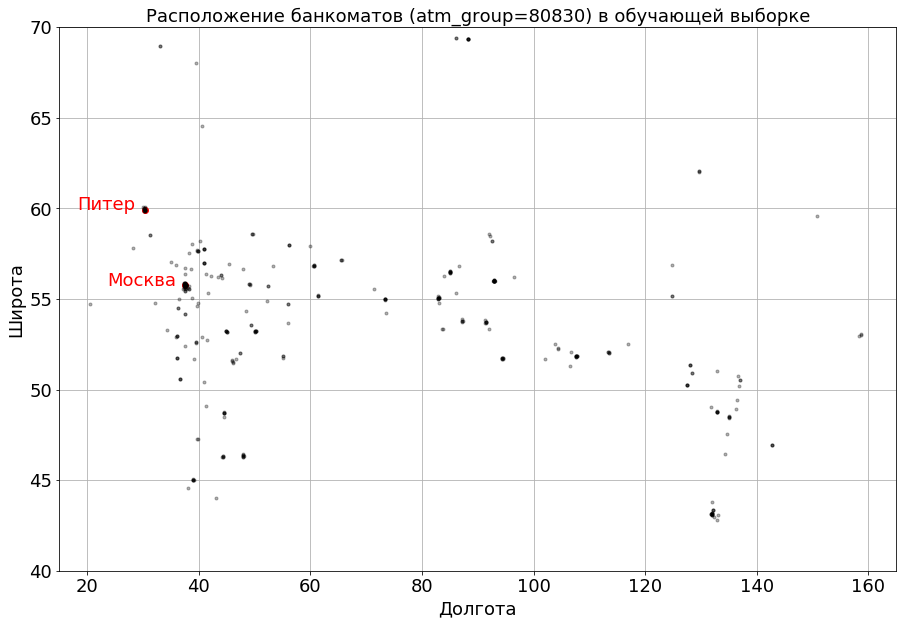

In [33]:
data = test
x = data['6-long'].values
y = data['6-lat'].values

for c in banks:
    plt.figure(figsize=figsize)
    plot_geo_meta(title='Расположение банкоматов (atm_group=%d) в обучающей выборке' % c)
    plot_geo_moscow_piter(1)
    s = data['0-bank'] == c
    plt.plot(x[s], y[s], 'k.', alpha=plot_alpha)
    
del data

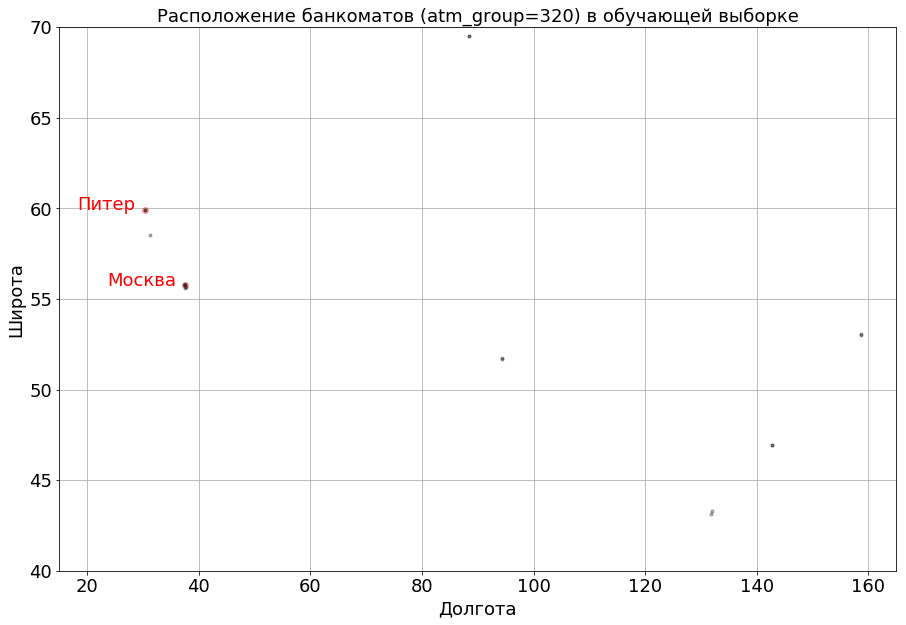

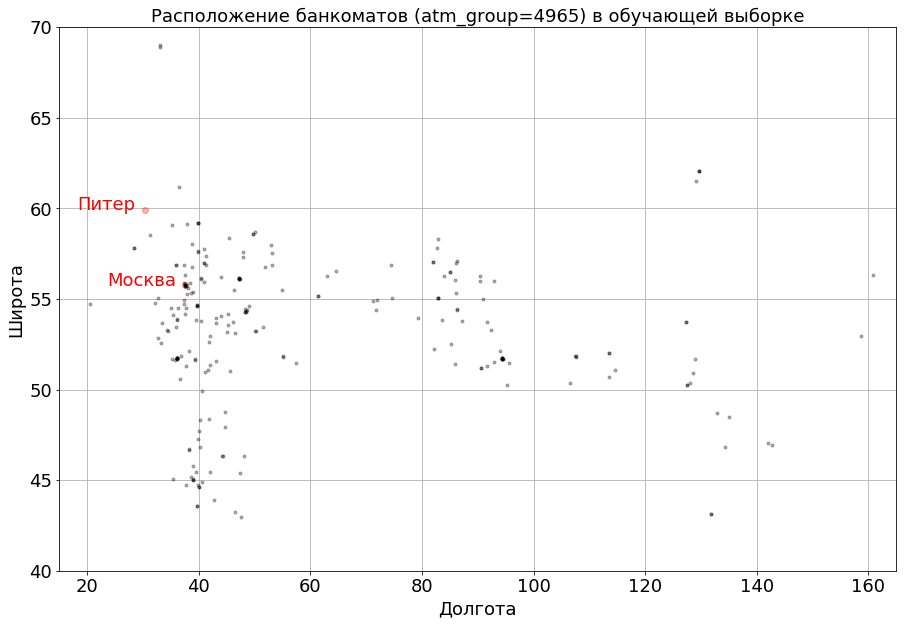

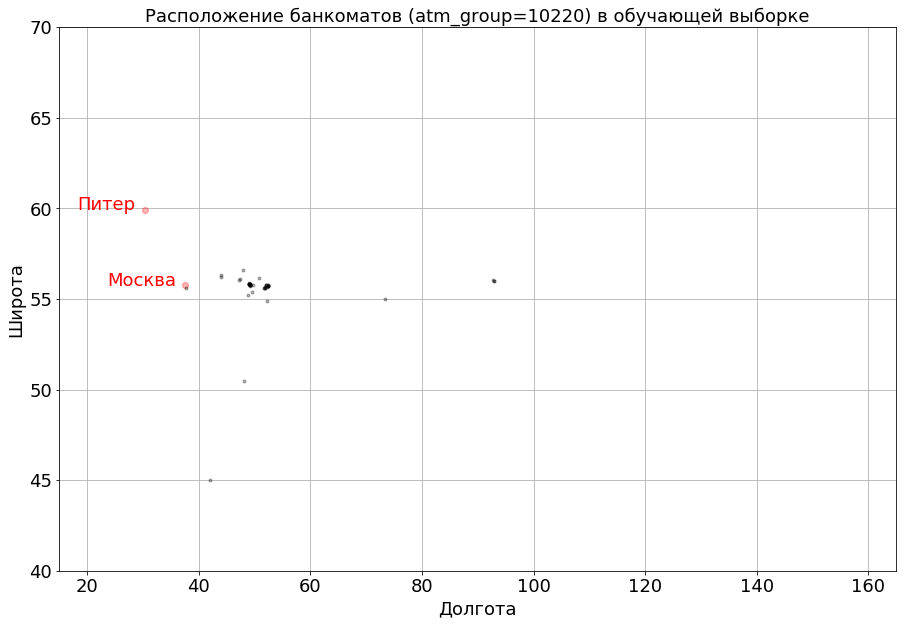

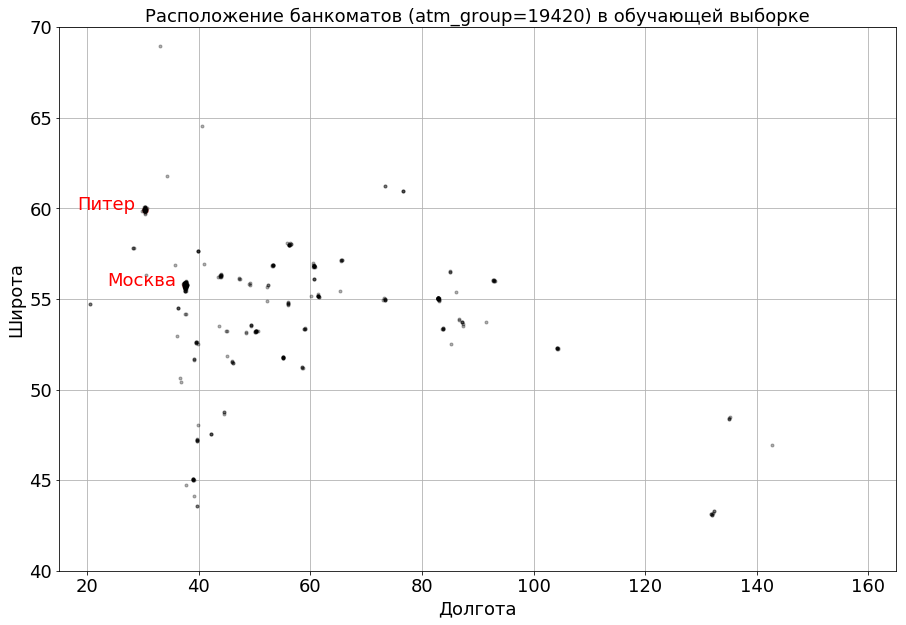

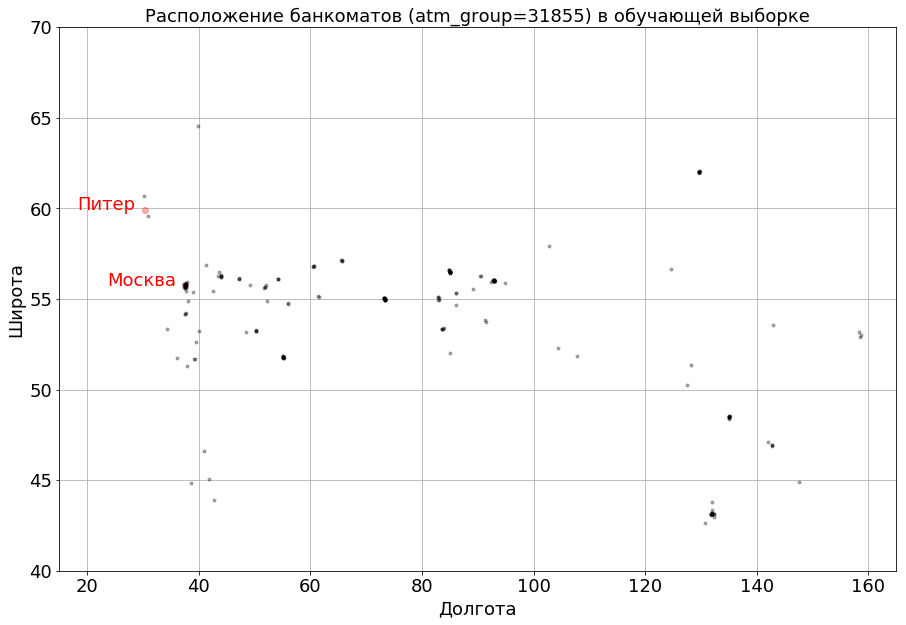

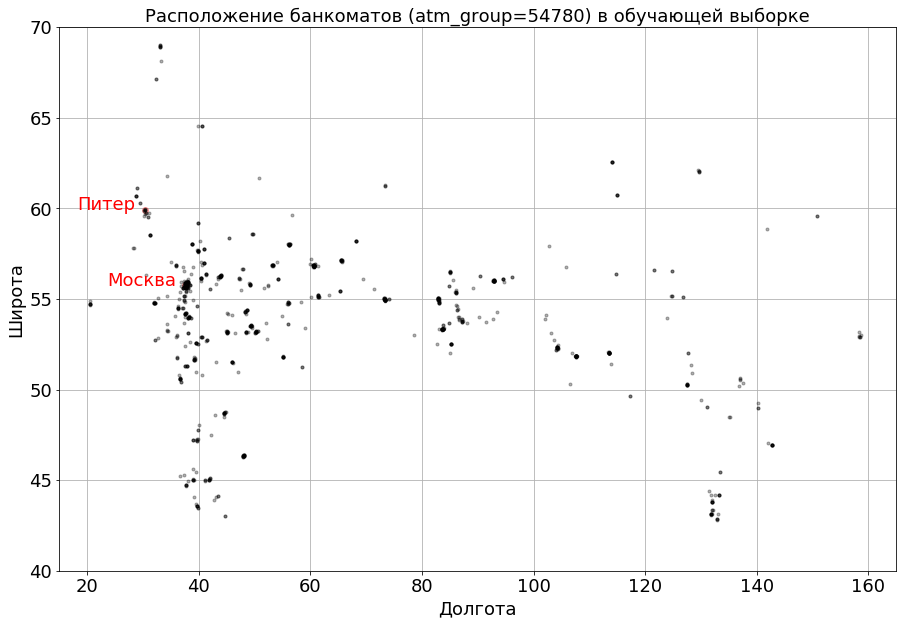

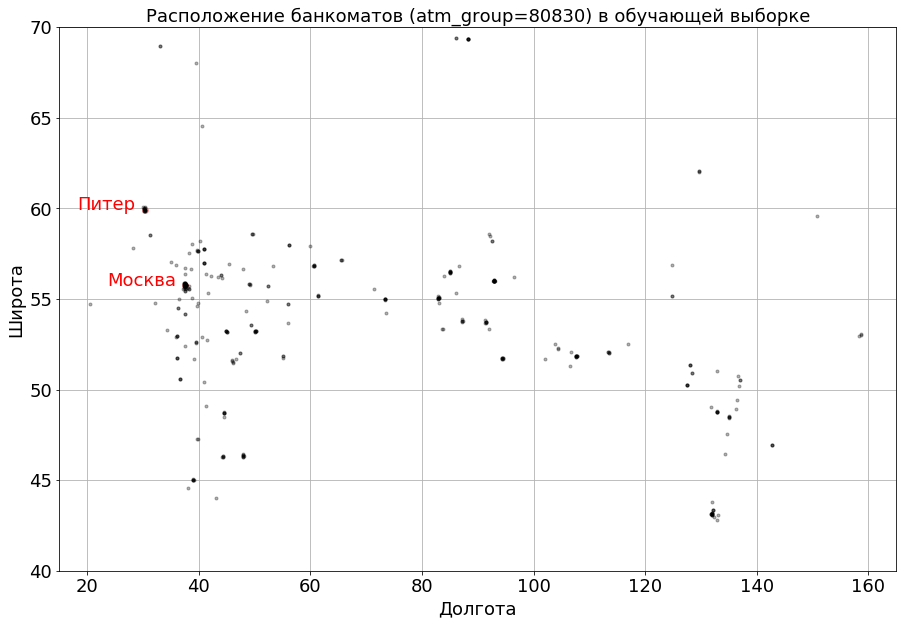

In [34]:
data = test
x = data['6-long'].values
y = data['6-lat'].values

for c in banks:
    plt.figure(figsize=figsize)
    plot_geo_meta(title='Расположение банкоматов (atm_group=%d) в обучающей выборке' % c)
    plot_geo_moscow_piter()
    s = data['0-bank'] == c
    plt.plot(x[s], y[s], 'k.', alpha=0.3)
    
del data

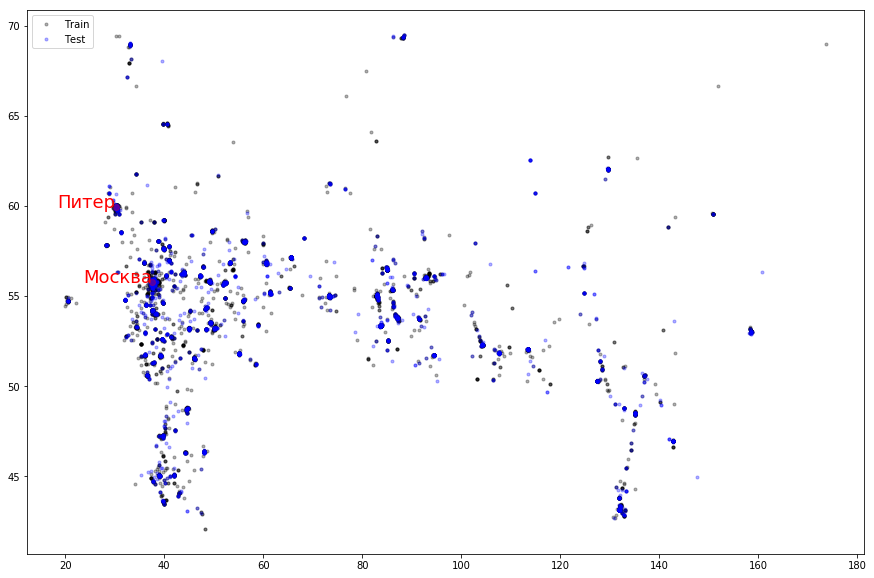

In [35]:
plt.figure(figsize=figsize)
for c, data in [('k', train), ('b', test)]:
    x = data['6-long'].values
    y = data['6-lat'].values
    plt.plot(x, y, '%so' % c, markersize=3, alpha=plot_alpha)
plt.legend(['Train', 'Test']);
plot_geo_moscow_piter()

del data

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


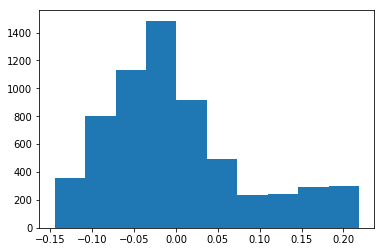

In [36]:
plt.hist(y_all['target']);

* Следует обратить внимание на крупные города
* Следует обратить внимание на города, в которых много/мало банкоматов
* Следует обратить внимание на соседей

In [37]:
test[test['address_rus'].isnull()].head()

,id,0-bank,address,address_rus,6-lat,6-long,is_train,index,test_index,train_index
1,2570.0,31855,UL. SERGEJA MAKEEVA MOSKVA,NaN,NaN,NaN,False,2,2,0
90,6662.0,54780,"D. 12, UL. AKADEMICHESKAY IRKUTSK G",NaN,NaN,NaN,False,91,91,0
99,484.0,19420,93 KRASNOARMEYSKAYA SAMARA,NaN,NaN,NaN,False,100,100,0
137,1469.0,19420,20 GUSINOBRODSKOE H/W NOVOSIBIRSK,NaN,NaN,NaN,False,138,138,0
146,3284.0,80830,"YA KOMSOMOLSK,19A Novo-Aleksandro",NaN,NaN,NaN,False,147,147,0


* Население
* Близость к Москве
* Близость к другим мегаполисам


* K-means фильтрация мелких кластеров
* Catboost
* VowpalWabbit
* K-means lat+long кластеризация
* Применить технику OOB
* K-means шумы (очистить). Отнести в отдельный кластер, например или добавить как фичу


* Создание фичей из презентах (например, счётчики)
* Граф. Есть ребро, если расстояние меньше медианы (среднего) , либо ребро единственное
* Насколько далеко центр города от банкомата
* Категории зданий, в которых стоят банкоматы
* Регион
* Расстояние от банкомата до центра города
* Время работы банкомата (ТЦ)
* Расстояние до ближайшего метро
* Расстояние до ближайшей остановки
* Расстояние до ближайшего транспорта
* Учитывать номер дома (сторона улицы, например)
* Детекция жилых кварталов и рабочих
* Совпадают ли адреса в address и address_rus?
* Часть данных следует заменить с помощью геокодера
* Все данные следует провалидировать
* Посчитать число банкоматов на расстоянии меньше, чем медиана/среднее
* Расстояние до другого atm_group
* Ввести для 


* После сильного изменения модели, следуте валидировать блендинг ещё раз
* Валидация групп фичей на паблике и на CV


* В baseline_boosters atm_group играет важную роль. В моей модели -- нет. Почему?
* Количество банкоматов по одному адресу ни на что не влияют
* Иметь несколько разбиений очень важно (в противном случае, скор падает)

# Генерация признаков

### Детекция городов в address_rus

In [19]:
print('Число городов, у которых нет координат:', data_all[data_all['address_rus'] == ''].shape[0])

Число городов, у которых нет координат: 420


In [20]:
def custom_parse_address(row):
    if len(row) == 0:
        return 'NULL'
    d = dict([(item[1], item[0]) for item in parse_address(row)])
    city = ''
    if 'city' in d:
        city = d['city']
    return city

data_all['city-temp'] = data_all['address_rus'].apply(custom_parse_address)

In [21]:
data_all.loc[missed_inds, 'city-temp'] = data_all[missed_inds]['city']
data_all['city'] = data_all['city-temp']
data_all['city'] = list(map(lambda x: x.replace('-', ' ').lower().replace('город ', '').replace(' город', '').replace('ё', 'e'), data_all['city']))
del data_all['city-temp']

In [22]:
# Не задетектились

d = {
    60: 'ст дружба-1',
    299: 'буденновский лес',
    300: 'буденновский лес',
    4443: 'екатеринбург',
    4444: 'екатеринбург',
    4445: 'екатеринбург',
    4446: 'екатеринбург',
    8374: 'усть-илимск',
    8386: 'усть-илимск',
    4609: 'усть-илимск'
}
for k in d:
    data_all.at[k, 'city'] = d[k]
data_all.at[data_all['city'] == '', 'city'] = data_all[data_all['city'] == ''].index.astype(str)

### Расстояние до центра города, до москвы и других крупных городов

In [23]:
R = 6373.0 # радиус земли в километрах

def distance(x,y):
    """
    Параметры
    ----------
    x : tuple, широта и долгота первой геокоординаты 
    y : tuple, широта и долгота второй геокоординаты 
    
    Результат
    ----------
    result : дистанция в километрах между двумя геокоординатами
    """
    lat_a, long_a, lat_b, long_b = map(radians, [*x,*y])    
    dlon = long_b - long_a
    dlat = lat_b - lat_a
    a = sin(dlat/2)**2 + cos(lat_a) * cos(lat_b) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [24]:
cities.loc[cities['Население'] < 30000, 'Население'] = cities['Население'][cities['Население'] < 30000].mean()

data_all['city_center_long'] = data_all['6-long']
data_all['city_center_lat'] = data_all['6-lat']
data_all['8-delta-city_center_lat'] = 0
data_all['8-delta-city_center_long'] = 0
data_all['8-delta-city_center'] = 0

data_all.loc[data_all['city'] == 'королев', '8-population'] = 222952
data_all.loc[data_all['city'] == 'королев', 'city_center_long'] = 55.9317
data_all.loc[data_all['city'] == 'королев', 'city_center_lat'] = 37.8519

data_all.loc[data_all['city'] == 'петропавловск', '8-population'] = 218031
data_all.loc[data_all['city'] == 'петропавловск', 'city_center_long'] = 54.8732
data_all.loc[data_all['city'] == 'петропавловск', 'city_center_lat'] = 69.1505

In [25]:
def get_cities(items, mask, data_all):
#     print('XXXX')
#     print(city)
    km = KMeans(n_clusters=items.shape[0], n_init=30, max_iter=300, random_state=42)
    km.fit([[x] for x in data_all.loc[mask, 'city_center_lat']])
    inds0 = np.where(km.labels_ == 0)[0]
    inds1 = np.where(km.labels_ == 1)[0]
    if inds0.shape[0] == 0:
        a = 1000000
    else:
        a = data_all.loc[mask, 'city_center_lat'].iloc[inds0[0]] - items.iloc[0]['Широта']
    if inds1.shape[0] == 0:
        b = 1000000
    else:
        b = data_all.loc[mask, 'city_center_lat'].iloc[inds1[0]] - items.iloc[0]['Широта']
#     print(np.sqrt(np.var(data_all.loc[mask, 'city_center_lat'].iloc[inds0] - items.iloc[0]['Широта'])))
#     print(np.sqrt(np.var(data_all.loc[mask, 'city_center_lat'].iloc[inds1] - items.iloc[0]['Широта'])))
    if a < b:
        return [(items.iloc[0], np.where(mask)[0][inds0]), (items.iloc[1], np.where(mask)[0][inds1])]
    return [(items.iloc[0], np.where(mask)[0][inds1]), (items.iloc[1], np.where(mask)[0][inds1])]

In [26]:
cities_set = set(cities['Город'])
data_all['8-population'] = cities['Население'].min()

for city in cities_set:
    mask = data_all['city'] == city
    items = cities[cities['Город'] == city]
    if items.shape[0] == 2 and mask.sum() > 1:
        z = get_cities(items, mask, data_all)
    if len(items) == 1:
        z = [(items.iloc[0], mask)]
    for item, mask in z:
        data_all.loc[mask, '8-population'] = float(item['Население'])
        data_all.loc[mask, '8-delta-city_center_lat'] = np.abs(float(item['Широта']) - data_all.loc[mask, 'city_center_lat'])
        data_all.loc[mask, '8-delta-city_center_long'] = np.abs(float(item['Долгота']) - data_all.loc[mask, 'city_center_long'])
        data_all.loc[mask, '8-delta-city_center'] = np.sqrt((float(item['Широта']) - data_all.loc[mask, 'city_center_lat']) ** 2 + (float(item['Долгота']) - data_all.loc[mask, 'city_center_long']) ** 2)
        data_all.loc[mask, 'region'] = item['Регион']
data_all['region'] = data_all['region'].fillna('NaN')

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:968: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)


In [27]:
data_all['8-is-big-500'] = np.uint(data_all['8-population'] > 500000)
data_all['8-is-big-1000'] = np.uint(data_all['8-population'] > 1000000)

In [28]:
msk_lat = float(cities[cities['Город'] == 'москва']['Широта'])
msk_long = float(cities[cities['Город'] == 'москва']['Долгота'])
sbp_lat = float(cities[cities['Город'] == 'санкт петербург']['Широта'])
sbp_long = float(cities[cities['Город'] == 'санкт петербург']['Долгота'])

data_all['8-delta-city_msk_lat'] = np.abs(msk_lat - data_all['city_center_lat'])
data_all['8-delta-city_msk_long'] = np.abs(msk_long - data_all['city_center_long'])
data_all['8-delta-city_msk'] = np.sqrt((msk_lat - data_all['city_center_lat']) ** 2 + (msk_long - data_all['city_center_long']) ** 2)

data_all['8-delta-city_sbp_lat'] = np.abs(sbp_lat - data_all['city_center_lat'])
data_all['8-delta-city_sbp_long'] = np.abs(sbp_long - data_all['city_center_long'])
data_all['8-delta-city_sbp'] = np.sqrt((sbp_lat - data_all['city_center_lat']) ** 2 + (sbp_long - data_all['city_center_long']) ** 2)

In [29]:
lat_500k = cities[cities['Население'] > 500000]['Широта'].values
long_500k = cities[cities['Население'] > 500000]['Долгота'].values






## TODO: допилить!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!










city_500k = cities[cities['Население'] > 500000]['Город'].values

lat_500k_prev = np.abs(lat_500k[0] - data_all['city_center_lat'])
long_500k_prev = np.abs(long_500k[0] - data_all['city_center_long'])
sqrt_500k_prev = np.sqrt((lat_500k[0] - data_all['city_center_lat']) ** 2 + (long_500k[0] - data_all['city_center_long']) ** 2)
for lat, long, city in zip(lat_500k[1:], long_500k[1:], city_500k[1:]):
    lat_500k_prev = list(map(min, zip(lat_500k_prev, np.abs(lat - data_all['city_center_lat']))))
    long_500k_prev = list(map(min, zip(long_500k_prev, np.abs(long - data_all['city_center_long']))))
    sqrt_500k_prev = list(map(min, zip(sqrt_500k_prev, np.sqrt((lat - data_all['city_center_lat']) ** 2 + (long - data_all['city_center_long']) ** 2))))

data_all['8-delta-city-500k_lat'] = lat_500k_prev
data_all['8-delta-city-500k_long'] = long_500k_prev
data_all['8-delta-city-500k'] = sqrt_500k_prev

In [30]:
data_all = pd.get_dummies(data_all, columns=['region'], prefix='8-region')

### Расстояния до ближайших банкоматов

In [31]:
knc = KNeighborsClassifier(metric=distance)

In [32]:
dots = data_all[['6-lat','6-long']].dropna()

In [33]:
knc.fit(X=dots, y=np.ones(dots.shape[0]))

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function distance at 0x7fe8b00b90d0>,
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [34]:
n_neighbors = 10
distances, indexes = knc.kneighbors(X=dots,n_neighbors=n_neighbors)

In [35]:
for i in range(1, n_neighbors):
    dots['1-distance_%d'%i] = distances[:,i]
    dots['1-indexes_%d'%i] = indexes[:,i]
    dots['1-var_%d'%i] = dots.iloc[:,dots.columns.str.contains('1-distance')].var(axis=1)

dots['1-mean'] = dots.iloc[:,dots.columns.str.contains('1-distance')].mean(axis=1)
dots['1-median'] = dots.iloc[:,dots.columns.str.contains('1-distance')].median(axis=1)

In [36]:
data_all = pd.concat([data_all, dots[dots.columns[2:]]], axis=1)

### Город размещения

In [37]:
value_counts_city = pd.merge(data_all[['city']], pd.DataFrame(data_all['city'].value_counts()).rename(columns={'city': 'count'}), left_on='city', right_index=True).sort_index()['count']
data_all['2-city-max-min-norm'] = (value_counts_city - value_counts_city.min()) / (value_counts_city.max() - value_counts_city.min())

city_value_counts = data_all['city'].value_counts()
t = 1
rare_cities = city_value_counts[city_value_counts < t].index
data_all['2-city-rank-less-average-%d' % t] = data_all['city'].rank()

for t in [2, 52]:
    rare_cities = city_value_counts[city_value_counts < t].index
    data_all['2-city-cumsum-less-bool-%d' % t] = data_all['city'].apply(lambda x: 1 if x in rare_cities else 0)

### K-means

In [38]:
def fill_centroid(km):
    centroids = np.array(km.labels_, dtype=np.float64)
    for i, v in enumerate(km.cluster_centers_):
        np.putmask(centroids, km.labels_ == i, km.cluster_centers_[i])
    return centroids

def fill_count(km):
    centroids = np.array(km.labels_, dtype=np.float64)
    for i, v in enumerate(km.cluster_centers_):
        np.putmask(centroids, km.labels_ == i, np.sum(km.labels_ == i))
    return centroids

In [39]:
for n_clusters in tqdm(range(30, 120, 10), desc='lon'):
    km = KMeans(n_clusters=n_clusters, n_init=30, max_iter=300, random_state=42)
    km.fit([[k] for k in list(data_all['6-long'].values)])
    data_all['3-rank-k-means-long-%d' % n_clusters] = km.labels_
    data_all['3-count-k-means-long-%d' % n_clusters] = fill_count(km)

for n_clusters in tqdm(range(30, 120, 10), desc='lat'):
    km = KMeans(n_clusters=n_clusters, n_init=30, max_iter=300, random_state=42)
    km.fit([[k] for k in list(data_all['6-lat'].values)])
    data_all['3-rank-k-means-lat-%d' % n_clusters] = km.labels_
    data_all['3-count-k-means-lat-%d' % n_clusters] = fill_count(km)

for n_clusters in tqdm([70, 120], desc='lat'):
    km = KMeans(n_clusters=n_clusters, n_init=30, max_iter=300, random_state=42)
    km.fit([[k] for k in list(data_all['6-lat'].values)])
    data_all['3-centroid-k-means-lat-%d' % n_clusters] = fill_centroid(km)
    
for n_clusters in tqdm([70, 120], desc='lon'):
    km = KMeans(n_clusters=n_clusters, n_init=30, max_iter=300, random_state=42)
    km.fit([[k] for k in list(data_all['6-long'].values)])
    data_all['3-centroid-k-means-long-%d' % n_clusters] = fill_centroid(km)

lon: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]


### Make ids

In [40]:
data_all['4-id_more_0_less_270'] = ((data_all['7-id'] >= 0) & (data_all['7-id'] <= 270)).astype(np.uint)
data_all['4-id_more_270_less_630'] = ((data_all['7-id'] >= 270) & (data_all['7-id'] <= 630)).astype(np.uint)
data_all['4-id_more_630_less_1910'] = ((data_all['7-id'] >= 630) & (data_all['7-id'] <= 1910)).astype(np.uint)
data_all['4-id_more_1910_less_2930'] = ((data_all['7-id'] >= 1910) & (data_all['7-id'] <= 2930)).astype(np.uint)
data_all['4-id_more_4450_less_6000'] = ((data_all['7-id'] >= 4450) & (data_all['7-id'] <= 6000)).astype(np.uint)
data_all['4-id_more_6000_less_7000'] = ((data_all['7-id'] >= 6000) & (data_all['7-id'] <= 7000)).astype(np.uint)

### DBSCAN id-index

In [41]:
rotate = lambda fi: np.array([[np.cos(fi), -np.sin(fi)], [np.sin(fi), np.cos(fi)]])

x, y = data_all['7-id'].values, data_all['7-index']

m = np.dot(np.array([x, y]).T, rotate(np.pi / 22.3 + np.pi / 2))
m = np.dot(m, np.array([[1, 0.12],[0, 1]]))
m = np.dot(m, np.array([[1, 0],[0, 0.15]]))

min_0 = m[:, 0].min()
min_1 = m[:, 1].min()
m = m - np.array([[min_0, min_1]] * m.shape[0])

dbscan = DBSCAN(eps=18, min_samples=8)
clusters = dbscan.fit_predict(m)

In [42]:
data_all['5-dbscan-index-id'] = clusters
data_all = pd.get_dummies(data_all, columns=['5-dbscan-index-id'], prefix='5-dbscan-index-id')

### Banki.ru

In [43]:
def extract_time_schedule(el):
    s = 1000
    f = -1
    weekend = 0
    stop = 0
    if el['type'] == 'atm':
        s, f, weekend = 0, 24, 1
    for sch in ['schedule_general', 'schedule_private_person', 'schedule_entities', 'schedule_vip']:
        stop |= el[sch].find('перерыв') > 0
        s = min([s] + list(map(int, re.findall('\d', el[sch]))))
        f = max([f] + list(map(int, re.findall('\d', el[sch]))))
        if el[sch].find('сб') > -1 or el[sch].find('вс') > -1:
            weekend = 1
    return s, f, weekend, stop

def extract_desc(desc, data, name):
    dots = []
    for item in desc:
        if item['longitude'] is not None and item['latitude'] is not None and len(item['longitude']) != 0 and len(item['latitude']) != 0:
            dots.append([item['longitude'], item['latitude']])
        else:
            dots.append([1000000, 10000000])

    knc = KNeighborsClassifier()
    knc.fit(X=dots , y=np.ones(len(dots)))

    ds, i_s = knc.kneighbors(X=list(zip(data['6-long'].values, data['6-lat'].values)), n_neighbors=1)

    matched = []
    for ind, item in enumerate(zip(ds, i_s)):
        d, i = item
        args = {
            '9-active': 0,
            '9-type': '',
            '9-time_schedule_s': 0,
            '9-time_schedule_f': 0,
            '9-time_schedule_week': 0,
            '9-time_schedule_stop': 0,
            '9-metro_name': 0,
            '9-without_weekend': 0,
            '9-is_round_the_clock': 0,
            '9-is_works_as_shop': 0,
            '9-is_at_closed_place': 0,
            '9-actual': 0,
            '9-comment_to_address': '',
            '9-bank_name': name,
            '9-index': data.index[ind],
        }
        if d[0] < 1e-3:
            el = desc[i[0]]
            a = extract_time_schedule(el)
            args = {
                '9-active': int(el['active']),
                '9-type': el['type'],
                '9-time_schedule_s': a[0],
                '9-time_schedule_f': a[1],
                '9-time_schedule_week': a[2],
                '9-time_schedule_stop': a[3],
                '9-metro_name': int(len(el['metro_name']) != 0),
                '9-without_weekend': el['without_weekend'],
                '9-is_round_the_clock': int(el['is_round_the_clock']),
                '9-is_works_as_shop': int(el['is_works_as_shop']),
                '9-is_at_closed_place': int(el['is_at_closed_place']),
                '9-actual': 1,
                '9-comment_to_address': el['comment_to_address'],
                '9-bank_name': name,
                '9-index': data.index[ind],
            }
            matched.append(args)
            continue
        matched.append(args)
    return matched

In [44]:
banks = {
    'Росбанк': 80830,
    'Ак Барс': 10220,
    'Альфа-Банк': 19420,
    'Газпромбанк': 31855,
    'Райффайзенбанк': 320,
    'Россельхозбанк': 4965,
    'Банк Уралсиб': 54780,
}
bank_dict = {}
for item in all_descs:
    bank_dict[item['bank_name']] = item['bank_id']
bank_dict = {}
for item in all_descs:
    bank_dict[item['bank_name']] = item['bank_id']

In [45]:
ress = []
for name in banks:
    descs = []
    for item in all_descs:
        if item['bank_name'] == name:
            descs.append(item)
    ress += extract_desc(descs, data_all[data_all['0-bank_base'] == banks[name]], name)

/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/home/hedgehogues/anaconda3/envs/ozon/lib/python3.6/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers 

In [46]:
answ = {}
for res in ress:
    answ[res['9-index']] = res

In [47]:
data_all = pd.concat([pd.DataFrame(answ).T, data_all], axis=1, sort=False)

In [48]:
data_all = pd.get_dummies(data_all, columns=['9-type'], prefix='9-type')

In [49]:
a = set(map(lambda x: x.lower, ['Гастроном-холл', 'ТЦ', 'ДО', 'БЦ', 'ТРЦ', 'Сити',  'ТКЦ', 'ТД', 'АЗС', 'Торговый', 'Рынок', 'Гастроном', 'Продовольственный', 'Кинотеатр', 'Магазин-салон', 'Театр']))
b = set(map(lambda x: x.lower, ['ОАО', 'OO', 'OOO']))
c = set(map(lambda x: x.lower, ['Автовокзал', 'Ж/д', 'метро', 'аэропорт']))
d = set(map(lambda x: x.lower, ['Супермаркет', 'Магазин', 'Универмаг', 'Красносельский', 'Гипермаркет', 'Покупочка', 'Минимаркет', 'Универсам', 'ГИПЕРМАРКЕТ', 'Окей', 'Гастроном', 'Дикси', 'Перекресток',  'М-Видео', 'Карусель', 'Лента', "О'Кей"]))

In [50]:
data_all['9-tc'] = data_all['9-comment_to_address'].str.replace('&nbsp;', ' ').str.replace('&laquo;', ' ').str.lower().str.split(' ').apply(lambda el: int(el[0] in a))
data_all['9-oao'] = data_all['9-comment_to_address'].str.replace('&nbsp;', ' ').str.replace('&laquo;', ' ').str.lower().str.split(' ').apply(lambda el: int(el[0] in b))
data_all['9-auto'] = data_all['9-comment_to_address'].str.replace('&nbsp;', ' ').str.replace('&laquo;', ' ').str.lower().str.split(' ').apply(lambda el: int(el[0] in c))
data_all['9-shops'] = data_all['9-comment_to_address'].str.replace('&nbsp;', ' ').str.replace('&laquo;', ' ').str.lower().str.split(' ').apply(lambda el: int(el[0] in d))

In [51]:
data_all['9-active'] = data_all['9-active'].astype(int)
data_all['9-time_schedule_s'] = data_all['9-time_schedule_s'].astype(int)
data_all['9-time_schedule_f'] = data_all['9-time_schedule_f'].astype(int)
data_all['9-time_schedule_week'] = data_all['9-time_schedule_week'].astype(int)
data_all['9-time_schedule_stop'] = data_all['9-time_schedule_stop'].astype(int)
data_all['9-metro_name'] = data_all['9-metro_name'].astype(int)
data_all['9-without_weekend'] = data_all['9-without_weekend'].astype(int)
data_all['9-is_round_the_clock'] = data_all['9-is_round_the_clock'].astype(int)
data_all['9-is_works_as_shop'] = data_all['9-is_works_as_shop'].astype(int)
data_all['9-is_at_closed_place'] = data_all['9-is_at_closed_place'].astype(int)
data_all['9-actual'] = data_all['9-actual'].astype(int)

### Graph (atms) (не используем, не докидывают)

In [ ]:
def get_random(G, v0, k, f):
    if len(list(G.neighbors(v0))) == 0:
        return 0
    s = 0
    for i in range(k):
        v1 = np.random.choice(list(G.neighbors(v0)))
        if G.neighbors(v1) == 0:
            continue
        v2 = np.random.choice(list(G.neighbors(v1)))
        if G.neighbors(v2) == 0:
            continue
        try:
            s += list(f(G, [(v0, v2)]))[0][2]
        except:
            s += 0
    return s / k

def calc_random_for_g(G, k, f):
    j = []
    for v in sorted(list(G.nodes())):
        j.append(get_random(G, v, k, f))
    return j

In [ ]:
knc = KNeighborsClassifier(metric=distance)
dots = data_all[['6-lat','6-long']].dropna()
knc.fit(X=dots, y=np.ones(dots.shape[0]))
n_neighbors = 30
distances, indexes = knc.kneighbors(X=dots,n_neighbors=n_neighbors)
median = np.median(distances[:, 1])
mean = np.mean(distances[:, 1])

In [ ]:
edges = []
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if i != indexes[i][j]:
            edges.append((i, indexes[i][j], distances[i][j]))
np.random.seed(42)
edges = [(
    e[0], 
    e[1],
    np.abs(np.random.normal(0.05, 0.01)) if e[2] < 1e-6 else e[2], 
    np.sum(distances[e[0]] < median) + np.sum(distances[e[1]] < median),
    np.sum(distances[e[0]] < mean) + np.sum(distances[e[1]] < mean))
    for e in edges]
edges = sorted(edges, key=lambda el: el[3])

for max_e in [10000, 20000, 40000, 100000, 150000, 250000]:
    G = nx.Graph()
    for i in range(distances.shape[0]):
        G.add_node(i)
    for e in edges[:max_e]:
        G.add_edge(e[0], e[1])
    data_all['10-mean-max_e=%d-graph-median-atms-degs' % max_e] = [e[1] for e in sorted(list(G.degree()), key=lambda el: el[0])]
    data_all['10-mean-max_e=%d-graph-median-atms-random-jaccard' % max_e] = calc_random_for_g(G, 10, nx.jaccard_coefficient)
    data_all['10-mean-max_e=%d-graph-median-atms-random-resource_allocation_index' % max_e] = calc_random_for_g(G, 10, nx.resource_allocation_index)
    data_all['10-mean-max_e=%d-graph-median-atms-random-adamic_adar_index' % max_e] = calc_random_for_g(G, 10, nx.adamic_adar_index)
    data_all['10-mean-max_e=%d-graph-median-atms-random-preferential_attachment' % max_e] = calc_random_for_g(G, 10, nx.preferential_attachment)
    data_all['10-mean-max_e=%d-graph-median-atms-random-cn_soundarajan_hopcroft' % max_e] = calc_random_for_g(G, 10, nx.cn_soundarajan_hopcroft)
    data_all['10-mean-max_e=%d-graph-median-atms-random-ra_index_soundarajan_hopcroft' % max_e] = calc_random_for_g(G, 10, nx.ra_index_soundarajan_hopcroft)
    data_all['10-mean-max_e=%d-graph-median-atms-random-within_inter_cluster' % max_e] = calc_random_for_g(G, 10, nx.within_inter_cluster)

In [ ]:
edges = []
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if i != indexes[i][j]:
            edges.append((i, indexes[i][j], distances[i][j]))
np.random.seed(42)
edges = [(
    e[0], 
    e[1],
    np.abs(np.random.normal(0.05, 0.01)) if e[2] < 1e-6 else e[2], 
    np.sum(distances[e[0]] < median) + np.sum(distances[e[1]] < median),
    np.sum(distances[e[0]] < mean) + np.sum(distances[e[1]] < mean))
    for e in edges]
edges = sorted(edges, key=lambda el: el[2])

for max_e in [20000, 80000, 150000, 200000, 250000]:
    G = nx.Graph()
    for i in range(distances.shape[0]):
        G.add_node(i)
    for e in edges[:max_e]:
        G.add_edge(e[0], e[1])
    data_all['10-meadian-max_e=%d-graph-median-atms-degs' % max_e] = [e[1] for e in sorted(list(G.degree()), key=lambda el: el[0])]
    data_all['10-meadian-max_e=%d-graph-median-atms-random-jaccard' % max_e] = calc_random_for_g(G, 10, nx.jaccard_coefficient)
    data_all['10-meadian-max_e=%d-graph-median-atms-random-resource_allocation_index' % max_e] = calc_random_for_g(G, 10, nx.resource_allocation_index)
    data_all['10-meadian-max_e=%d-graph-median-atms-random-adamic_adar_index' % max_e] = calc_random_for_g(G, 10, nx.adamic_adar_index)
    data_all['10-meadian-max_e=%d-graph-median-atms-random-preferential_attachment' % max_e] = calc_random_for_g(G, 10, nx.preferential_attachment)
    data_all['10-meadian-max_e=%d-graph-median-atms-random-cn_soundarajan_hopcroft' % max_e] = calc_random_for_g(G, 10, nx.cn_soundarajan_hopcroft)
    data_all['10-meadian-max_e=%d-graph-median-atms-random-ra_index_soundarajan_hopcroft' % max_e] = calc_random_for_g(G, 10, nx.ra_index_soundarajan_hopcroft)
    data_all['10-meadian-max_e=%d-graph-median-atms-random-within_inter_cluster' % max_e] = calc_random_for_g(G, 10, nx.within_inter_cluster)

In [ ]:
edges = []
for i in range(distances.shape[0]):
    for j in range(distances.shape[1]):
        if i != indexes[i][j]:
            edges.append((i, indexes[i][j], distances[i][j]))
np.random.seed(42)
edges = [(
    e[0], 
    e[1],
    np.abs(np.random.normal(0.05, 0.01)) if e[2] < 1e-6 else e[2], 
    np.sum(distances[e[0]] < median) + np.sum(distances[e[1]] < median),
    np.sum(distances[e[0]] < mean) + np.sum(distances[e[1]] < mean))
    for e in edges]
edges = sorted(edges, key=lambda el: el[2])

for max_e in [10000, 20000, 40000, 100000, 150000, 250000]:
    G = nx.Graph()
    for i in range(distances.shape[0]):
        G.add_node(i)
    for e in edges[:max_e]:
        G.add_edge(e[0], e[1])
    data_all['10-dist-max_e=%d-graph-median-atms-degs' % max_e] = [e[1] for e in sorted(list(G.degree()), key=lambda el: el[0])]
    data_all['10-dist-max_e=%d-graph-median-atms-random-jaccard' % max_e] = calc_random_for_g(G, 10, nx.jaccard_coefficient)
    data_all['10-dist-max_e=%d-graph-median-atms-random-resource_allocation_index' % max_e] = calc_random_for_g(G, 10, nx.resource_allocation_index)
    data_all['10-dist-max_e=%d-graph-median-atms-random-adamic_adar_index' % max_e] = calc_random_for_g(G, 10, nx.adamic_adar_index)
    data_all['10-dist-max_e=%d-graph-median-atms-random-preferential_attachment' % max_e] = calc_random_for_g(G, 10, nx.preferential_attachment)
    data_all['10-dist-max_e=%d-graph-median-atms-random-cn_soundarajan_hopcroft' % max_e] = calc_random_for_g(G, 10, nx.cn_soundarajan_hopcroft)
    data_all['10-dist-max_e=%d-graph-median-atms-random-ra_index_soundarajan_hopcroft' % max_e] = calc_random_for_g(G, 10, nx.ra_index_soundarajan_hopcroft)
    data_all['10-dist-max_e=%d-graph-median-atms-random-within_inter_cluster' % max_e] = calc_random_for_g(G, 10, nx.within_inter_cluster)

### Yandex ratings

In [52]:
mean_score = []
mean_people = []
mean_divide = []

median_score = []
median_people = []
median_divide = []

var_score = []
var_people = []
var_divide = []

count_score = []
count_people = []
count_divide = []

count_cats = []
cats = []
all_cats = []

random_rating_1 = []
random_rating_2 = []
random_rating_3 = []
random_rating_4 = []
random_rating_5 = []

metro = []
stop = []

np.random.seed(42)

for i in range(data_all.shape[0]):
    with open('yandex/data/' + str(i) + '.json') as fd:
        item = json.load(fd)
    metro.append(100000 if np.isnan(item[0]) else item[0])
    stop.append(100000 if np.isnan(item[1]) else item[1])
    
    cats.append([])
    score = []
    people = []
    for cat in item[2]:
        cats[-1].append(cat[2])
        all_cats.append(cat[2])
        people.append(cat[0])
        score.append(cat[1])
        
    count_cats.append(len(cats[-1]))
    
    if len(score) == 0:
        score = [0, 0]
        people = [0, 0]
    
    mean_score.append(np.mean(score))
    mean_people.append(np.mean(people))
    mean_divide.append(np.mean(people) / (1 + np.mean(score)))
    
    median_score.append(np.median(score))
    median_people.append(np.median(people))
    median_divide.append(np.median(people) / (1+np.median(score)))
    
    var_score.append(np.var(score))
    var_people.append(np.var(people))
    var_divide.append(np.var(people) / (1+np.var(score)))
    
    count_score.append(np.sum(score))
    count_people.append(np.sum(people))
    count_divide.append(np.sum(people) / (1+np.sum(score)))
    
    random_rating_1.append(np.random.choice(score))
    random_rating_2.append(np.random.choice(score))
    random_rating_3.append(np.random.choice(score))
    random_rating_4.append(np.random.choice(score))
    random_rating_5.append(np.random.choice(score))

In [53]:
data_all['11-mean-score'] = mean_score
data_all['11-mean-people'] = mean_people
data_all['11-mean-divide'] = mean_divide

data_all['11-median-score'] = median_score
data_all['11-median-people'] = median_people
data_all['11-median-divide'] = median_divide

data_all['11-count-score'] = count_score
data_all['11-count-people'] = count_people
data_all['11-count-divide'] = count_divide

data_all['11-var-score'] = var_score
data_all['11-var-people'] = var_people
data_all['11-var-divide'] = var_divide

data_all['11-count-cats'] = count_cats
data_all['11-metro'] = metro
data_all['11-stops'] = stop

data_all['11-random-score-1'] = random_rating_1
data_all['11-random-score-2'] = random_rating_2
data_all['11-random-score-3'] = random_rating_3
data_all['11-random-score-4'] = random_rating_4
data_all['11-random-score-5'] = random_rating_5

In [54]:
vectorizer = TfidfVectorizer()

In [55]:
svd = TruncatedSVD(n_components=10)
svd_cats = svd.fit_transform(vectorizer.fit_transform([' '.join(cat) for cat in cats]))
df = pd.DataFrame(svd_cats).add_prefix('11-cat-')

In [56]:
data_all = pd.concat([data_all, df], axis=1)

### Funcs

In [59]:
def tarin_valid_split(x, y, n_splits=20, test_size=0.2):
    splits = []
    for n in range(n_splits):
        X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=test_size)
        splits.append({
            'x_train': X_train,
            'x_valid': X_valid,
            'y_valid': y_valid,
            'y_train': y_train
        })
    return splits

class Algorithm:
    
    def __init__(self, alpha=0, beta=0, max_depth=20, n_estimators_0=150, n_estimators_1=600):
        
        param = {
            'objective': 'regression',  
            'max_depth': max_depth,
            'colsample_bytre': 0.8,
            'subsample': 0.8, 
            'learning_rate': 0.033,
            'n_estimators': n_estimators_1,
            'verbosity': -1,
            'n_jobs': -1
        }
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = 1 - (alpha + beta)
        
        self.gbm = lgb.LGBMRegressor(**param)
        self.xgb = XGBRegressor(max_depth=max_depth, learning_rate=0.033, n_estimators=n_estimators_0, n_jobs=-1)
        self.rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators_0, n_jobs=-1)
    
    def fit(self, x_, y_):
        self.gbm.fit(x_, y_, eval_metric='rmse')
        if not (self.alpha == 0 and self.beta == 0):
            self.xgb.fit(x_, y_)
            self.rf.fit(x_, y_)
        
    def predict(self, x_):
        c = self.gamma * self.gbm.predict(x_)
        a = 0
        b = 0
        if not (self.alpha == 0 and self.beta == 0):
            a = self.alpha * self.rf.predict(x_)
            b = self.beta * self.xgb.predict(x_)
        return a + b + c

# BaseLines

### Mean

In [42]:
rmse([y_all[y_all['is_train']]['base_target'].mean()] * y_all[y_all['is_train']].shape[0], y_all[y_all['is_train']]['base_target'])

0.08584553998788125

### Median

In [60]:
rmse([y_all[y_all['is_train']]['base_target'].median()] * y_all[y_all['is_train']].shape[0], y_all[y_all['is_train']]['base_target'])

0.08737704540840263

### Grouping by id (Mean)

In [61]:
center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].mean()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].mean()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].mean()

In [62]:
center_target = list(y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].values)
left_target = list(y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].values)
right_target = list(y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].values)

In [63]:
rmse(center_target + left_target + right_target, [center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

0.05515199427038081

### Grouping by id (Median)

In [64]:
center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].median()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].median()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].median()

In [65]:
center_target = list(y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].values)
left_target = list(y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].values)
right_target = list(y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].values)

In [66]:
rmse(center_target + left_target + right_target, [center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

0.05535991575648429

### Blending (2 solve groupping)

In [67]:
center_target = list(y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].values)
left_target = list(y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].values)
right_target = list(y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].values)

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].median()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].median()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].median()
res = np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].mean()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].mean()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].mean()
res += np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

rmse(center_target + left_target + right_target, res / 2)

0.05520404805937104

### Blending (3 solve. groupping + mean)

In [68]:
center_target = list(y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].values)
left_target = list(y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].values)
right_target = list(y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].values)

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].median()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].median()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].median()
res = np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].mean()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].mean()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].mean()
res += np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

res += np.array([y_all[y_all['is_train']]['base_target'].mean()] * y_all[y_all['is_train']].shape[0])

rmse(center_target + left_target + right_target, res / 3)

0.058884351645543606

### Blending (3 solve. groupping + median)

In [69]:
center_target = list(y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].values)
left_target = list(y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].values)
right_target = list(y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].values)

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].median()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].median()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].median()
res = np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].mean()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].mean()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].mean()
res += np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

res += np.array([y_all[y_all['is_train']]['base_target'].median()] * y_all[y_all['is_train']].shape[0])

rmse(center_target + left_target + right_target, res / 3)

0.05905163884767783

### Blending (4 solve)

In [70]:
center_target = list(y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].values)
left_target = list(y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].values)
right_target = list(y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].values)

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].median()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].median()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].median()
res = np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

center = y_all[y_all['is_train'] & (y_all['7-id'] >= 2930) & (y_all['7-id'] <= 4450)]['base_target'].mean()
left = y_all[y_all['is_train'] & (y_all['7-id'] < 2930)]['base_target'].mean()
right = y_all[y_all['is_train'] & (y_all['7-id'] > 4450)]['base_target'].mean()
res += np.array([center] * len(center_target) + [left] * len(left_target) + [right] * len(right_target))

res += np.array([y_all[y_all['is_train']]['base_target'].median()] * y_all[y_all['is_train']].shape[0])
res += np.array([y_all[y_all['is_train']]['base_target'].mean()] * y_all[y_all['is_train']].shape[0])

rmse(center_target + left_target + right_target, res / 4)

0.06380592255860242

# CV

In [57]:
columns_for_drop += ['is_train', '1-var_1', 'train_index', 'test_index', 'the_same_address_terminals', 'city', 'region', 'city_center_long', 'city_center_lat', '9-comment_to_address', '9-index', '9-bank_name']
columns_for_drop = list(np.unique(columns_for_drop))
actual_cols = data_all.columns.difference(columns_for_drop)        
X = data_all.loc[data_all.is_train & ~data_all.address_fail, actual_cols.difference(['address_fail'])]
actual_cols = list(actual_cols.difference(['address_fail']))
Y = y_all.loc[y_all.is_train & ~y_all.address_fail, 'target']

In [74]:
splits = tarin_valid_split(X, Y, test_size=0.1, n_splits=5)

errs = []
for i, split in enumerate(splits):
    print(i)
    x = split['x_train']
    y = split['y_train']
    alg = Algorithm(alpha=0.8, beta=0.1, max_depth=50, n_estimators_0=180, n_estimators_1=700)
    alg.fit(x, y)
    x = split['x_valid']
    y = split['y_valid']
    pred = alg.predict(x)
    errs.append(rmse(y, pred))

0
1
2
3
4


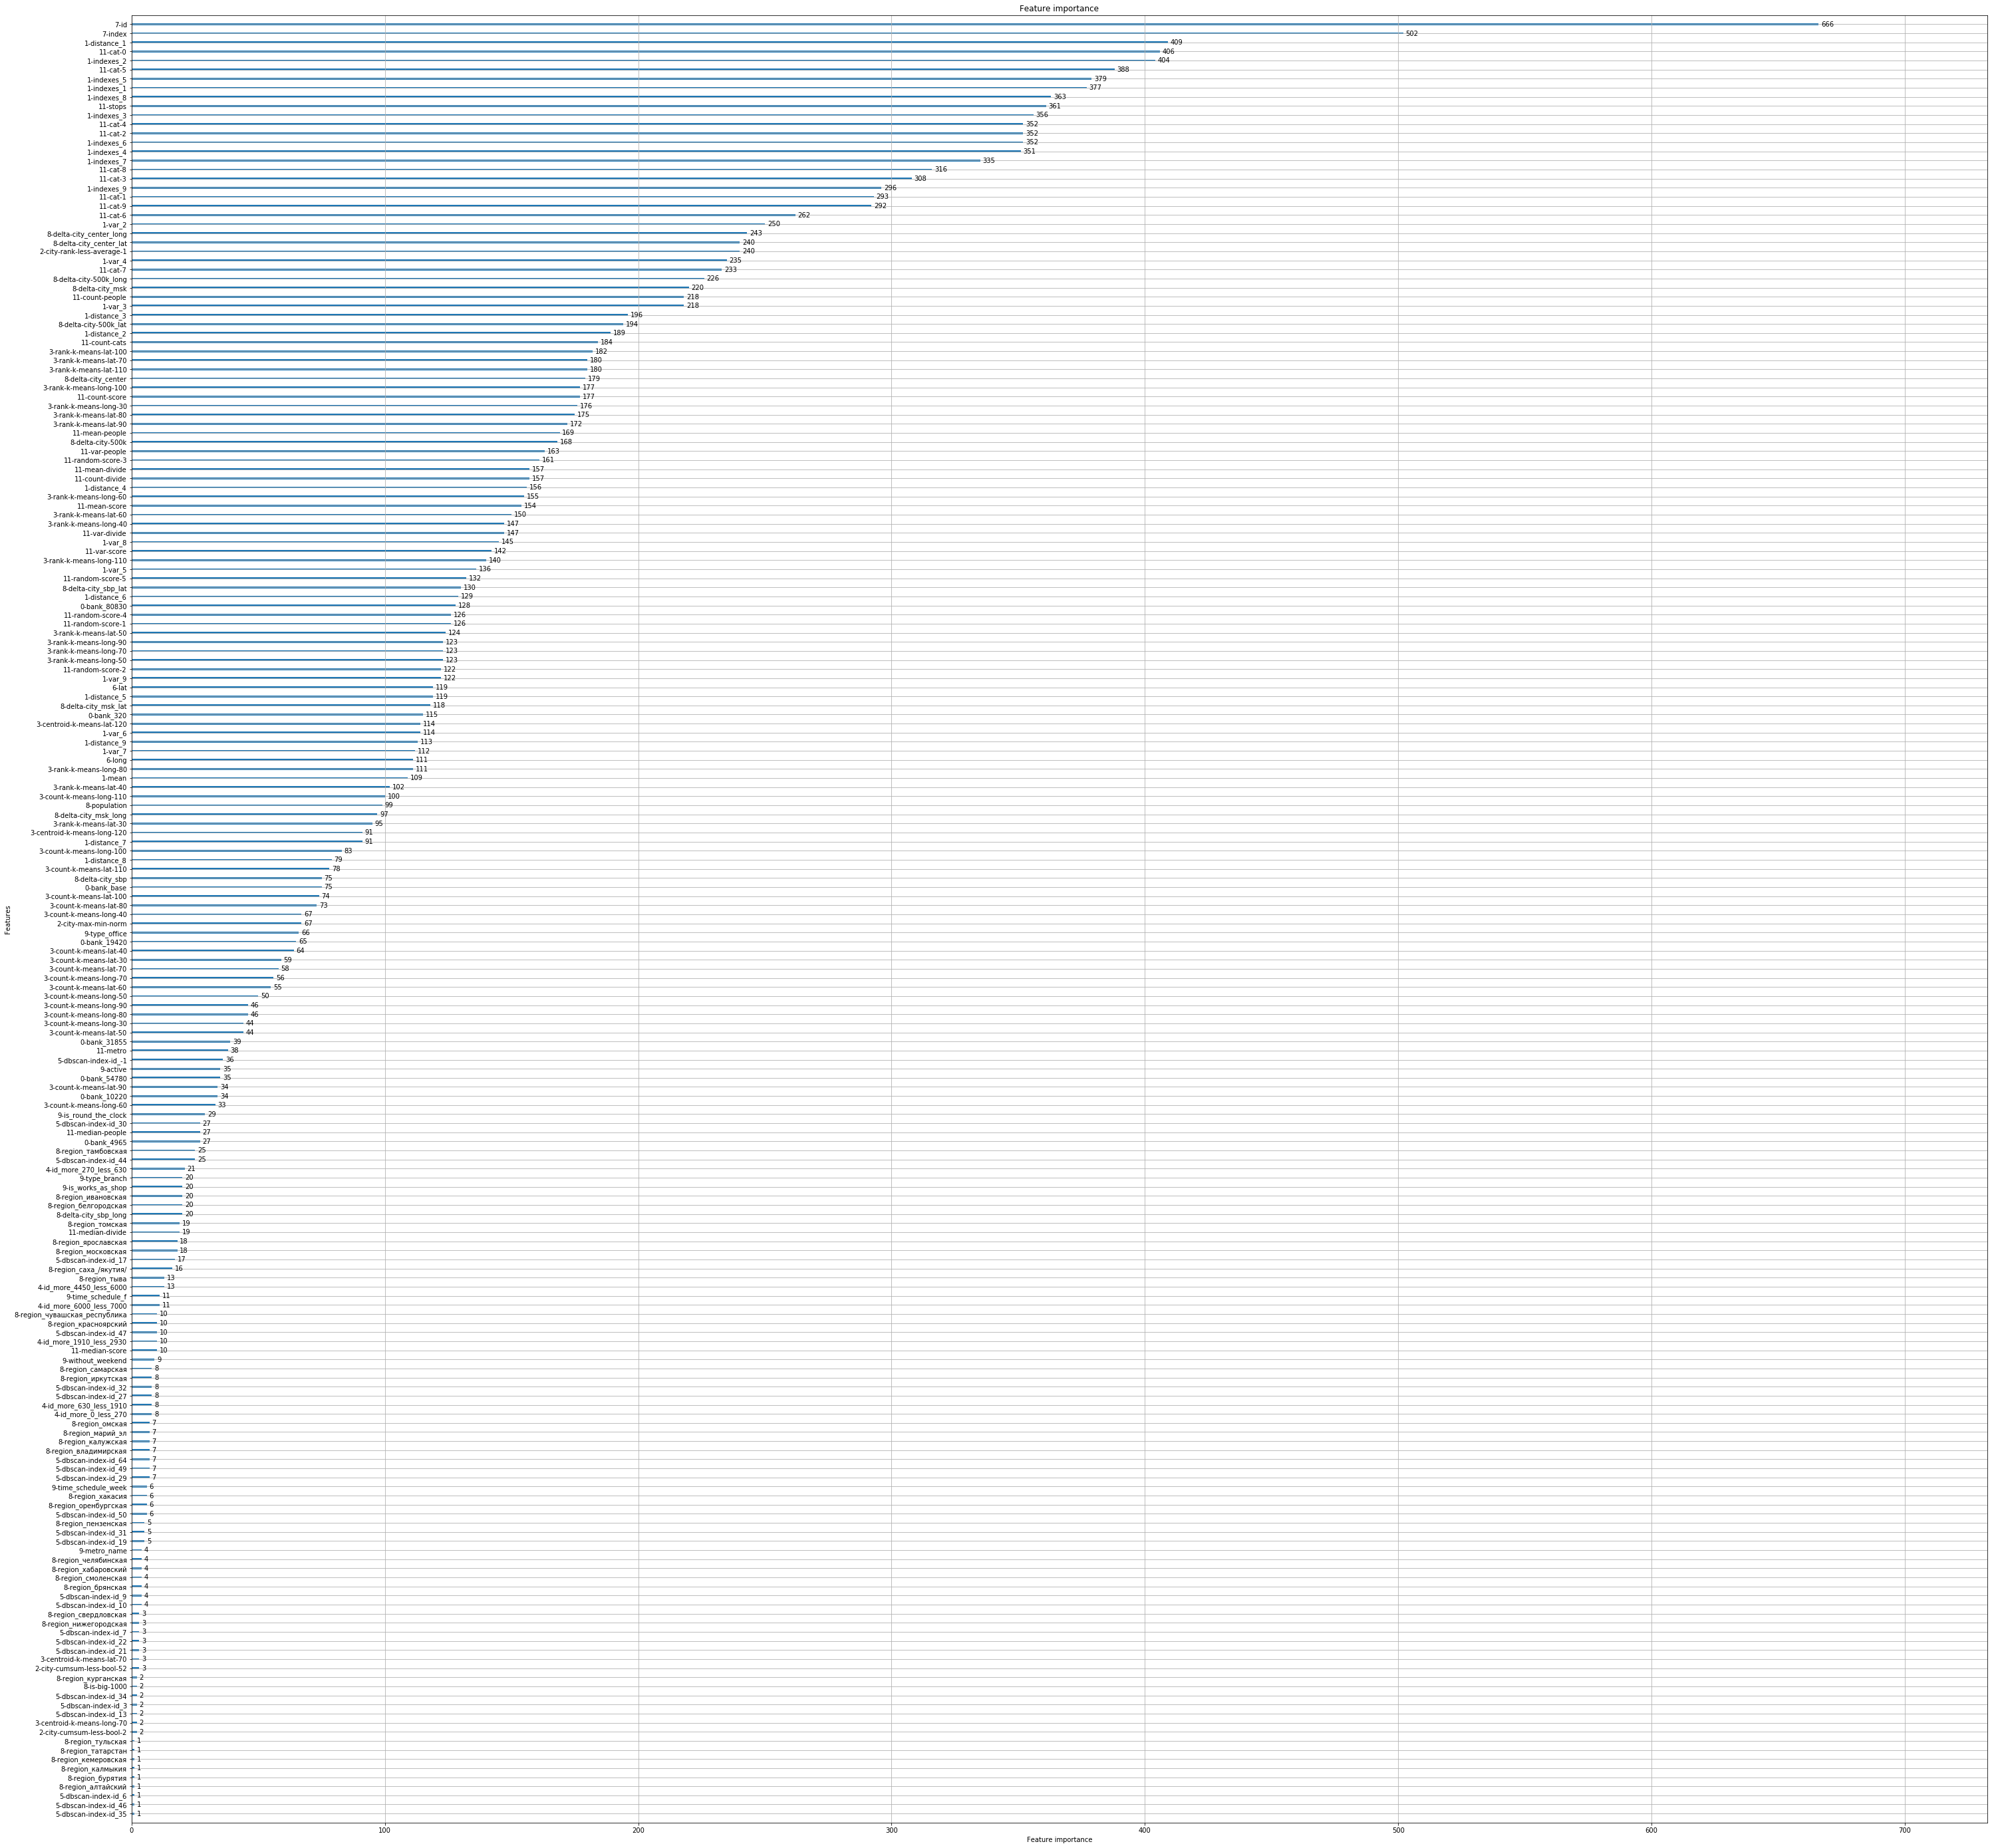

In [76]:
lgb.plot_importance(alg.gbm, figsize=(50, 50))
plt.savefig('1.png')

In [75]:
np.mean(errs), np.sqrt(np.var(errs))

(0.041257267792057864, 0.0017392288815096277)

In [63]:
np.mean(errs), np.sqrt(np.var(errs))

(0.04104622254167946, 0.0007324620294330067)

In [61]:
np.mean(errs), np.sqrt(np.var(errs))

(0.04198968100009347, 0.0006227749644256714)

# Submit

In [77]:
columns_for_drop += ['is_train', '1-var_1', 'train_index', 'test_index', 'the_same_address_terminals', 'city', 'region', 'city_center_long', 'city_center_lat', '9-comment_to_address', '9-index', '9-bank_name']
columns_for_drop = list(np.unique(columns_for_drop))
actual_cols = data_all.columns.difference(columns_for_drop)

In [78]:
list(actual_cols)

['0-bank_10220',
 '0-bank_19420',
 '0-bank_31855',
 '0-bank_320',
 '0-bank_4965',
 '0-bank_54780',
 '0-bank_80830',
 '0-bank_base',
 '1-distance_1',
 '1-distance_2',
 '1-distance_3',
 '1-distance_4',
 '1-distance_5',
 '1-distance_6',
 '1-distance_7',
 '1-distance_8',
 '1-distance_9',
 '1-indexes_1',
 '1-indexes_2',
 '1-indexes_3',
 '1-indexes_4',
 '1-indexes_5',
 '1-indexes_6',
 '1-indexes_7',
 '1-indexes_8',
 '1-indexes_9',
 '1-mean',
 '1-median',
 '1-var_2',
 '1-var_3',
 '1-var_4',
 '1-var_5',
 '1-var_6',
 '1-var_7',
 '1-var_8',
 '1-var_9',
 '11-cat-0',
 '11-cat-1',
 '11-cat-2',
 '11-cat-3',
 '11-cat-4',
 '11-cat-5',
 '11-cat-6',
 '11-cat-7',
 '11-cat-8',
 '11-cat-9',
 '11-count-cats',
 '11-count-divide',
 '11-count-people',
 '11-count-score',
 '11-mean-divide',
 '11-mean-people',
 '11-mean-score',
 '11-median-divide',
 '11-median-people',
 '11-median-score',
 '11-metro',
 '11-random-score-1',
 '11-random-score-2',
 '11-random-score-3',
 '11-random-score-4',
 '11-random-score-5',
 '1

In [80]:
X = data_all.loc[data_all.is_train & ~data_all.address_fail, actual_cols.difference(['address_fail'])]
Y = y_all.loc[y_all.is_train & ~y_all.address_fail, 'target']

n_splits = 17
splits = tarin_valid_split(X, Y, n_splits=n_splits)

algs = []
for split in tqdm(splits):
    x = split['x_train']
    y = split['y_train']
    algs.append(Algorithm(alpha=0.8, beta=0.1, max_depth=50, n_estimators_0=180, n_estimators_1=700))
    algs[-1].fit(x, y)


100%|██████████| 17/17 [08:53<00:00, 31.01s/it]


In [81]:
X_test = data_all.loc[~data_all.is_train, actual_cols.difference(['address_fail'])]
res = None
for i in range(n_splits):
    print(i)
    split = splits[i]
    if res is None:
        res = algs[i].predict(X_test)
    else:
        res += algs[i].predict(X_test)
res /= len(splits)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [82]:
submit = pd.DataFrame(res, index=test.index,columns=['target'])

In [83]:
submit.to_csv('data/submit.csv')